## Dependencies loading

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
import os
from pmdarima.arima import auto_arima

pd.set_option("display.max_columns", 500)

# np.random.seed(1916) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

## Project setup

In [129]:
raw_input_data_path = "../data/input"
preprocessed_output_data_path = "../data/output"

## Load dataset

In [130]:
df = pd.read_csv(f"{preprocessed_output_data_path}/train.csv", index_col=0)
df_test = pd.read_csv(f"{preprocessed_output_data_path}/test.csv", index_col=0)

## Feature engineering

### Feature engineering during ETL

This procedure was applied during data preparation process in the previous notebook.

### Feature engineering after ETL

We will split this chapter into three parts: 
* one dimensional approach
* interactions
* time-series approach

#### FE - one dimensional approach

In [131]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df.etr)
    plt.plot()

To be honest feature creation process is already half done - dataset gathers financial transformations. But we will consider some additional transformations, variable by variable!

We know that all variables till **roa** has *wild* distribution! They look like that more or less due to the fact that many companies are not publishing all data in financial statements, and in such a case 0 was inputted. 

**sektor**

Here let's apply just One Hot Encoding (drop first category to omit collinearity). In our opinion it's a bad idea to group them (high heterogeneity).

In [132]:
df = pd.get_dummies(df, columns=["sektor"], prefix=["sektor"], drop_first=True)

In [133]:
df_test = pd.get_dummies(
    df_test, columns=["sektor"], prefix=["sektor"], drop_first=True
)

In [134]:
print(df.shape, df_test.shape)

(3993, 49) (363, 49)


**gielda**

Here let's apply just One Hot Encoding (drop first category to omit collinearity). In our opinion it's a bad idea to group them (high heterogeneity).

In [135]:
df = pd.get_dummies(df, columns=["gielda"], prefix=["gielda"], drop_first=True)

In [136]:
df_test = pd.get_dummies(
    df_test, columns=["gielda"], prefix=["gielda"], drop_first=True
)

In [137]:
print(df.shape, df_test.shape)

(3993, 52) (363, 52)


**ta**

Literature suggests that logarithm of total assets can approximate size of a company. This impact is visible! What is more this variable seems to follow PowerLow Distribution

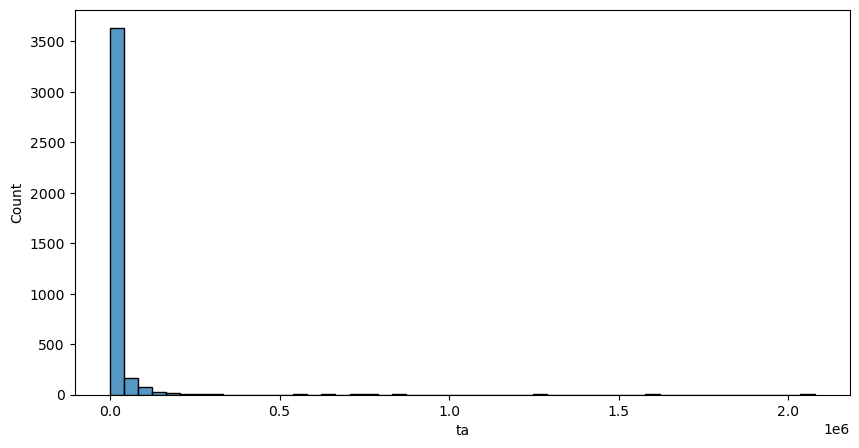

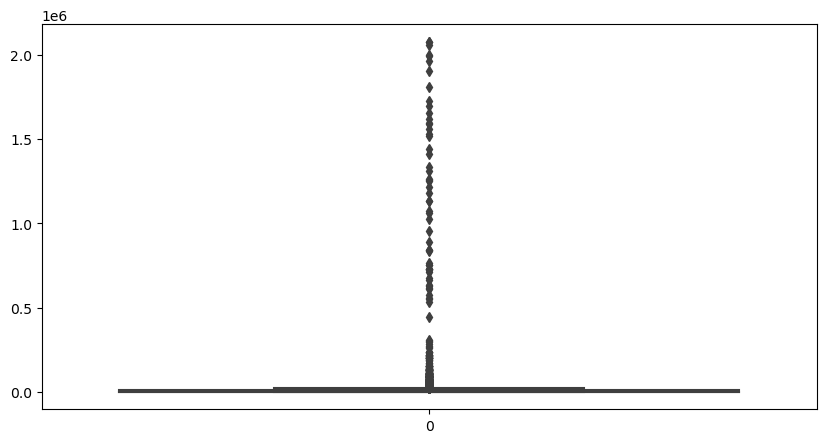

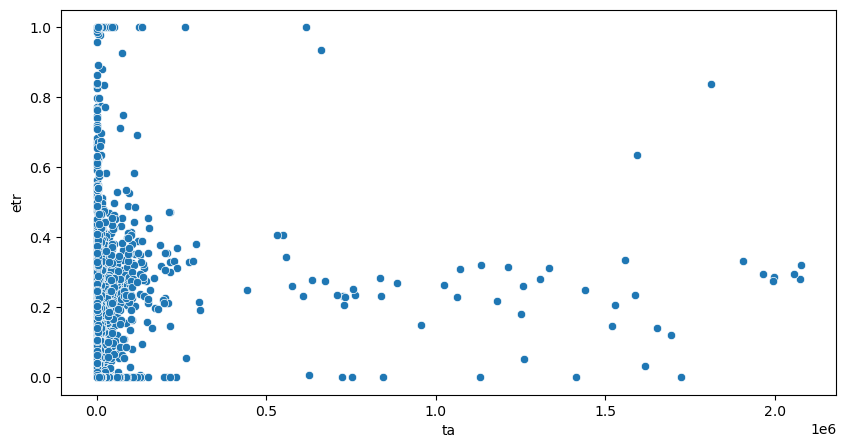

In [138]:
quick_viz(df.ta)

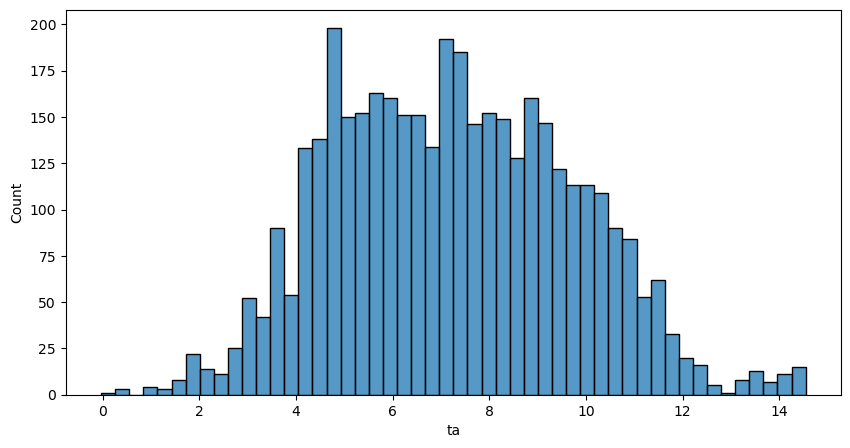

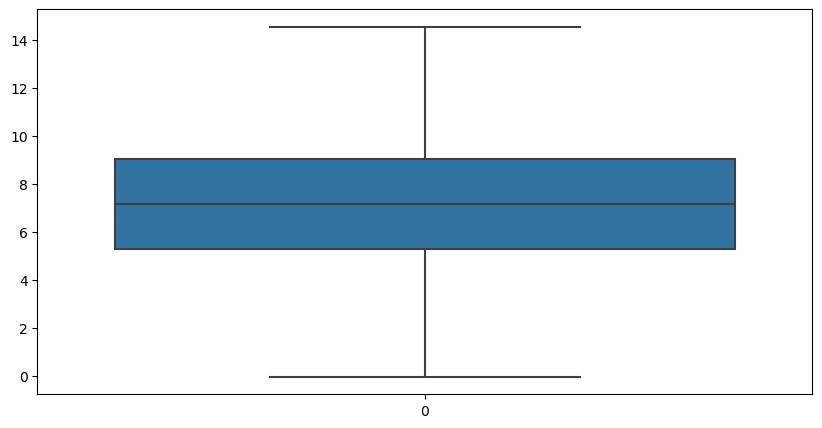

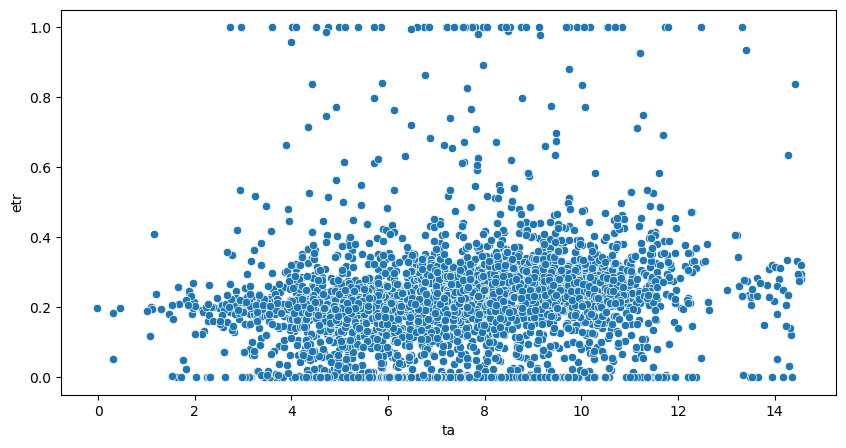

In [139]:
quick_viz(np.log(df.ta))

In [140]:
df["ta_log"] = np.log(df.ta)

In [141]:
df_test["ta_log"] = np.log(df_test.ta)

In [142]:
print(df.shape, df_test.shape)

(3993, 53) (363, 53)


**txt**

Here we can try to create bins. We will use decision-tree to obtain such results.

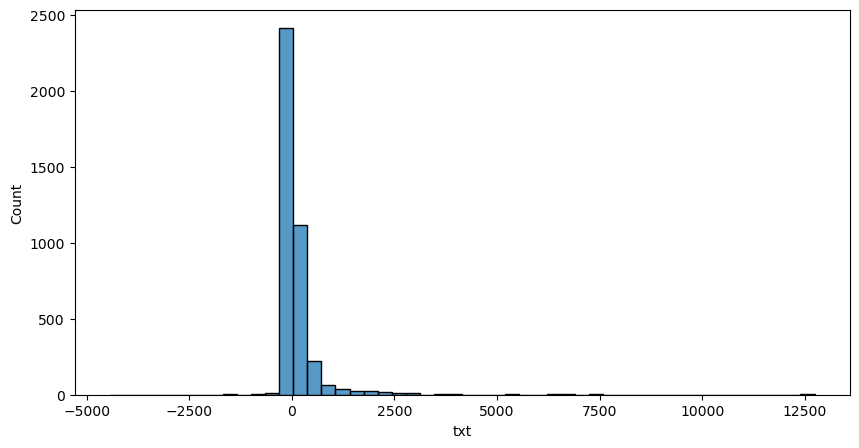

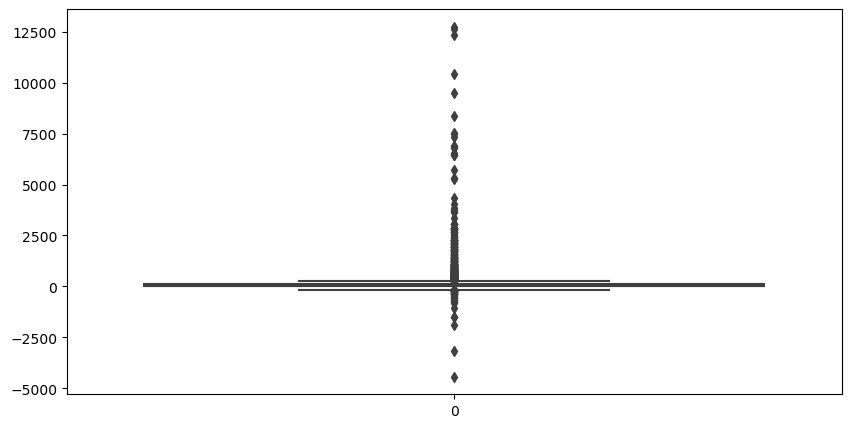

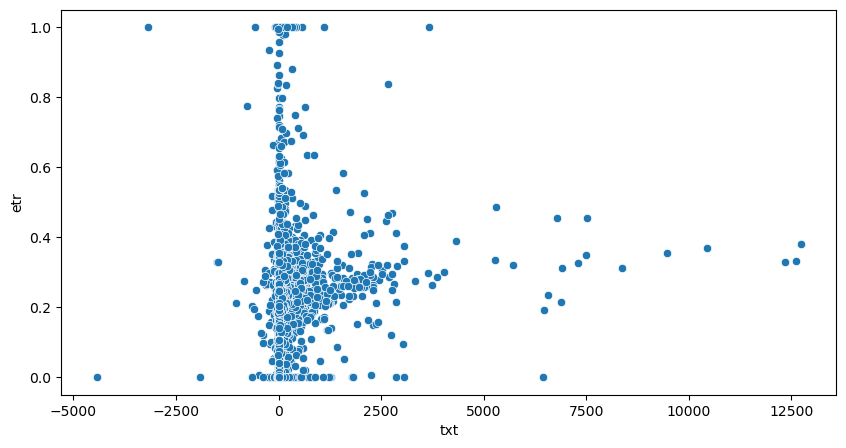

In [143]:
quick_viz(df["txt"])

We will try to obtain very shallow DT (to fight against overfitting)

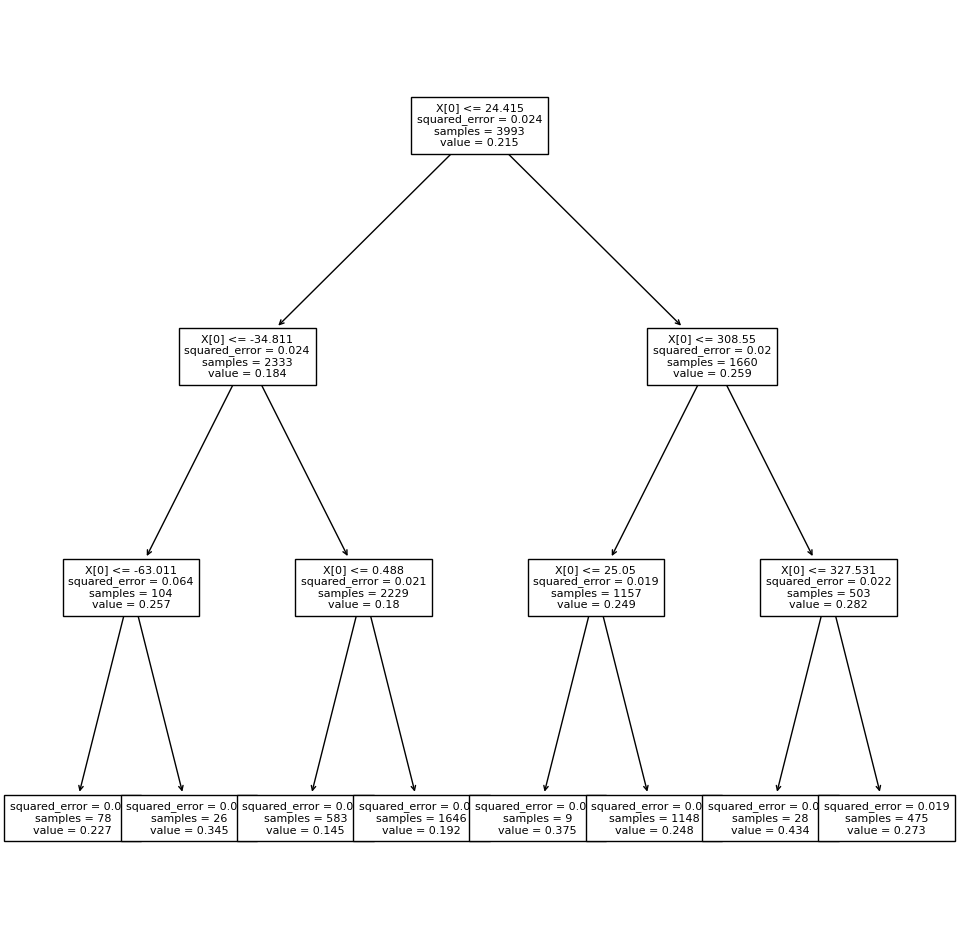

In [144]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(np.array(df.txt).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [145]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [146]:
df["txt_cat"] = pd.cut(df.txt, splits)
df_test["txt_cat"] = pd.cut(df_test.txt, splits)

<AxesSubplot:xlabel='rok', ylabel='count'>

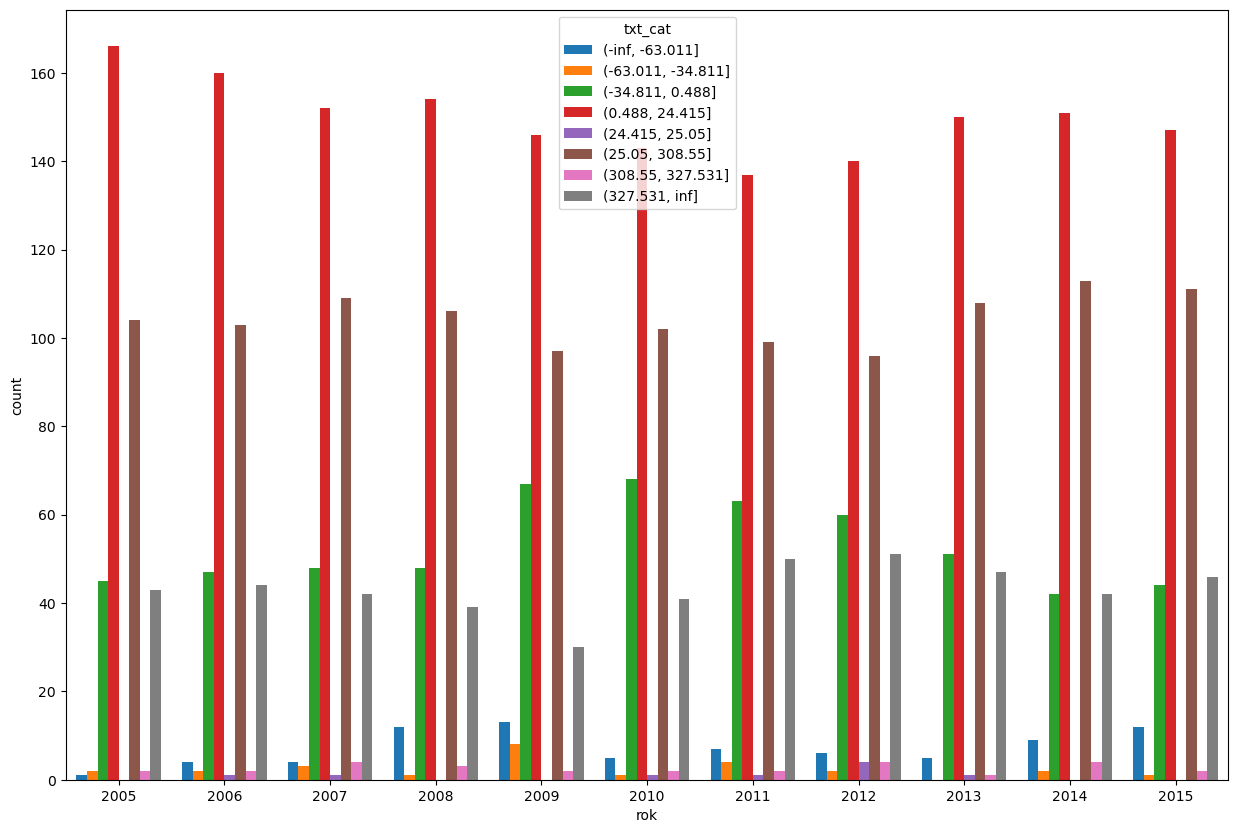

In [147]:
plt.figure(figsize=(15, 10))
sns.countplot(x="rok", hue="txt_cat", data=df, dodge=True, saturation=1, orient="v")

In [148]:
df = pd.get_dummies(df, columns=["txt_cat"], prefix=["txt_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["txt_cat"], prefix=["txt_cat"], drop_first=True
)

In [149]:
print(df.shape, df_test.shape)

(3993, 60) (363, 60)


**pi**

Let's apply the same approach as in case of txt

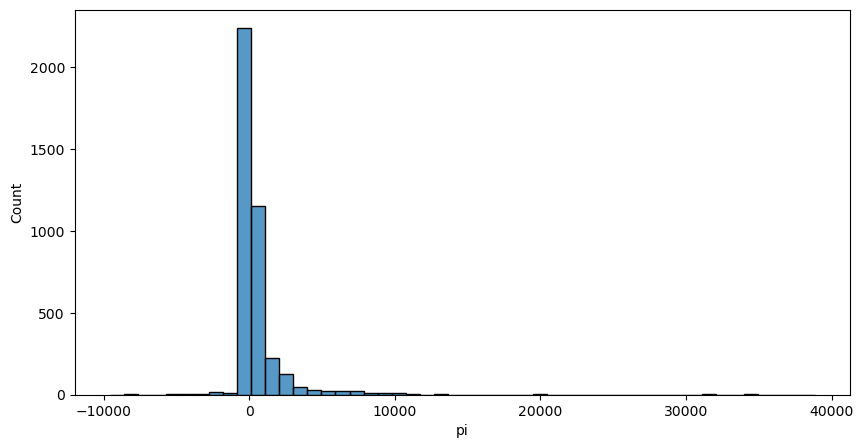

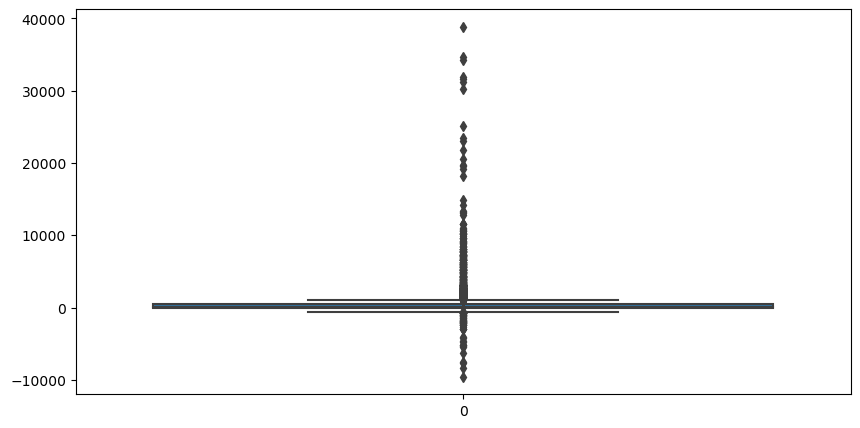

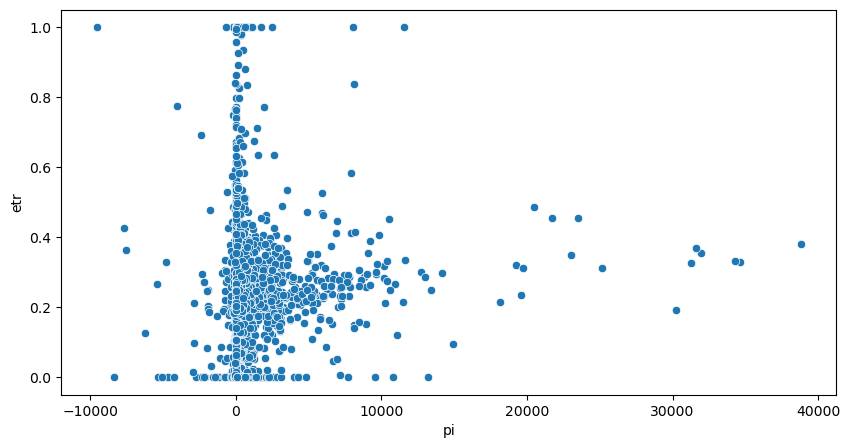

In [150]:
quick_viz(df["pi"])

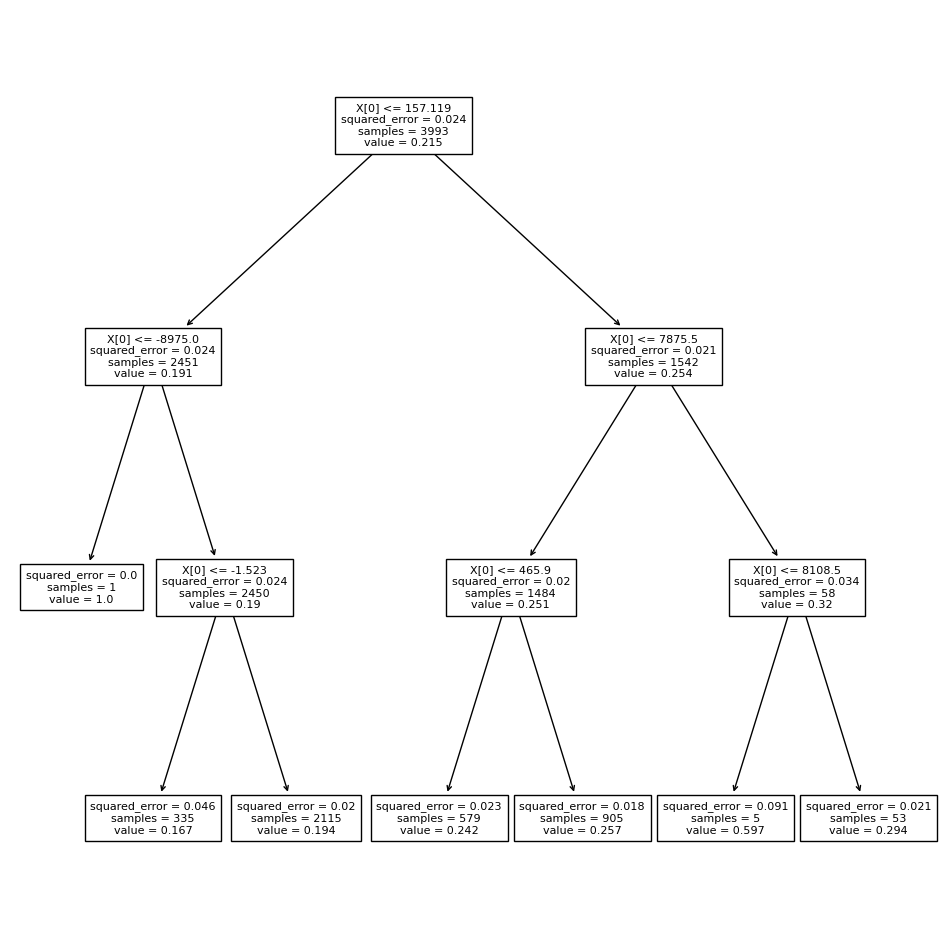

In [151]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(np.array(df["pi"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [152]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [153]:
df["pi_cat"] = pd.cut(df["pi"], splits)
df_test["pi_cat"] = pd.cut(df_test["pi"], splits)

In [154]:
df = pd.get_dummies(df, columns=["pi_cat"], prefix=["pi_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["pi_cat"], prefix=["pi_cat"], drop_first=True
)

In [155]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 66) (363, 66)
True


**str** - let's discretize this variable

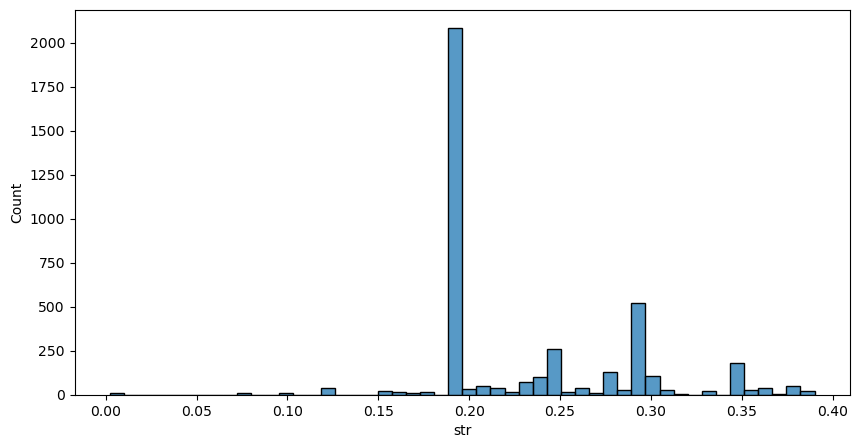

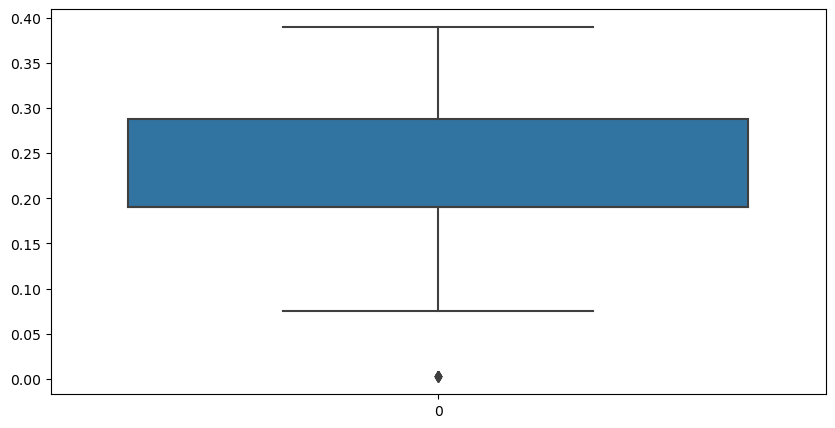

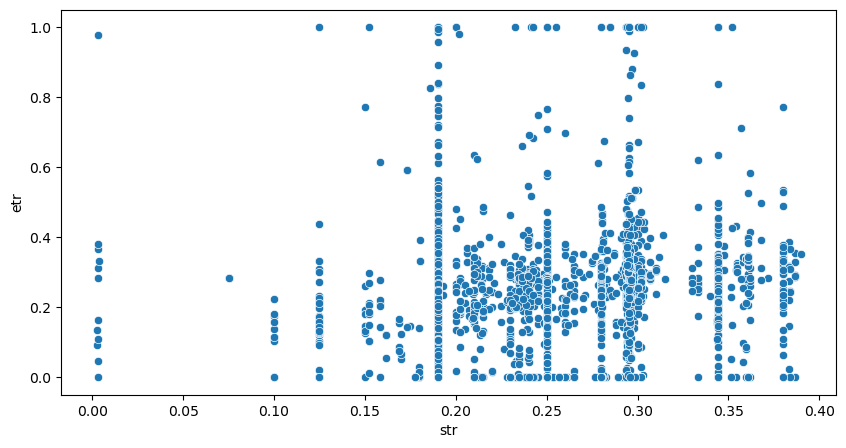

In [156]:
quick_viz((df["str"]))

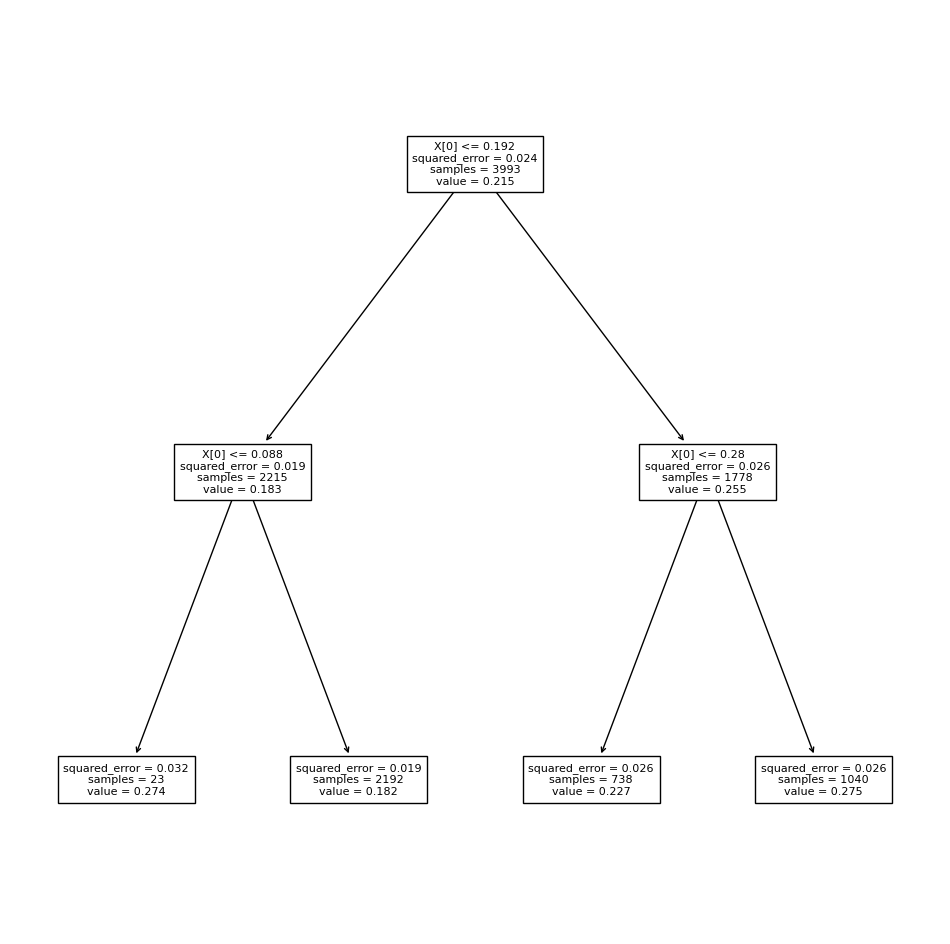

In [157]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["str"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [158]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [159]:
df["str_cat"] = pd.cut(df["str"], splits)
df_test["str_cat"] = pd.cut(df_test["str"], splits)

In [160]:
df = pd.get_dummies(df, columns=["str_cat"], prefix=["str_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["str_cat"], prefix=["str_cat"], drop_first=True
)

In [161]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 69) (363, 69)
True


**xrd** - here we can check if company reports research and development expenditure (dichotomous variable)

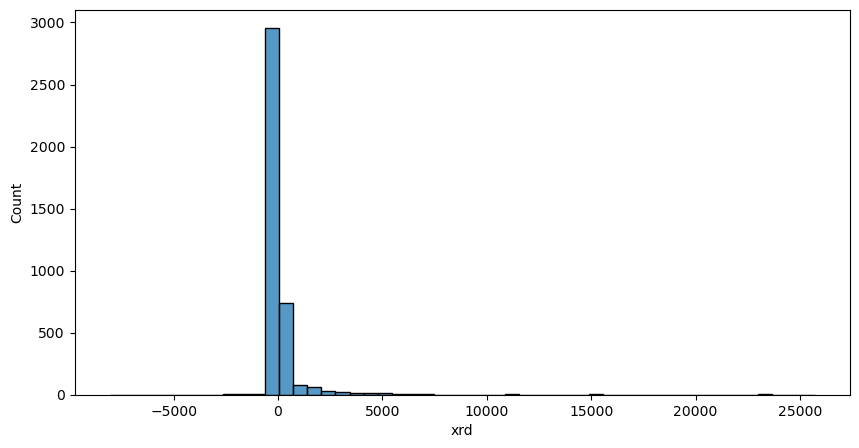

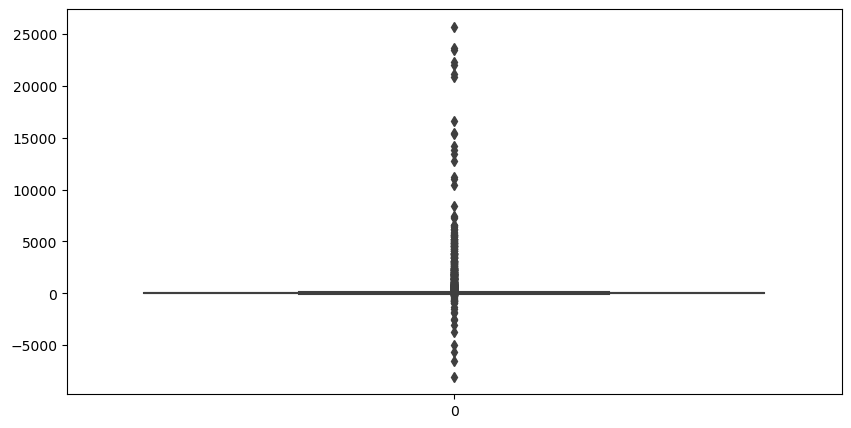

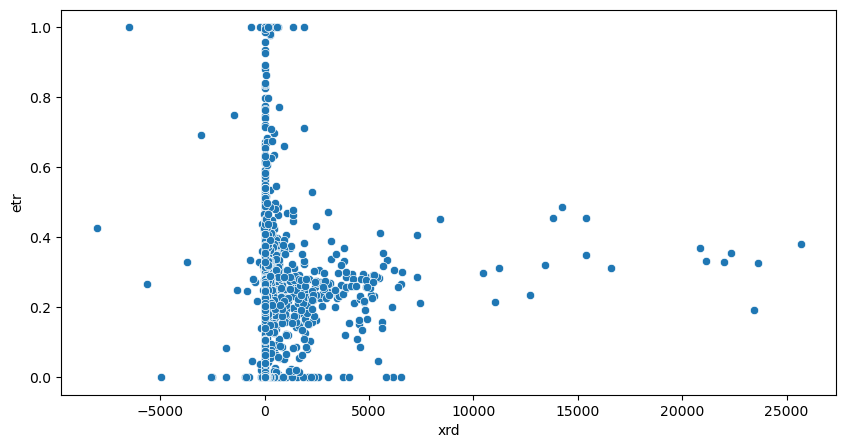

In [162]:
quick_viz(df.xrd)

In [163]:
df["xrd_exists"] = np.where(df.xrd != 0, 1, 0)
df_test["xrd_exists"] = np.where(df_test.xrd != 0, 1, 0)

In [164]:
df.xrd_exists.value_counts()

0    2623
1    1370
Name: xrd_exists, dtype: int64

In [165]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 70) (363, 70)
True


**ni** - dichotomous variable profit or loss

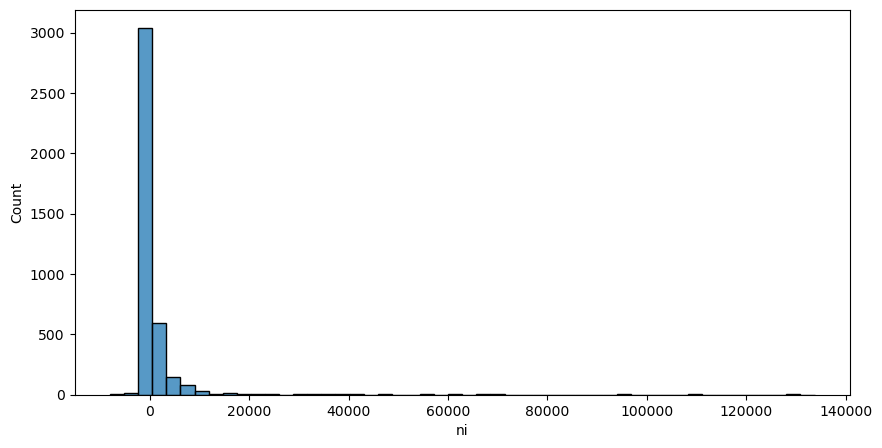

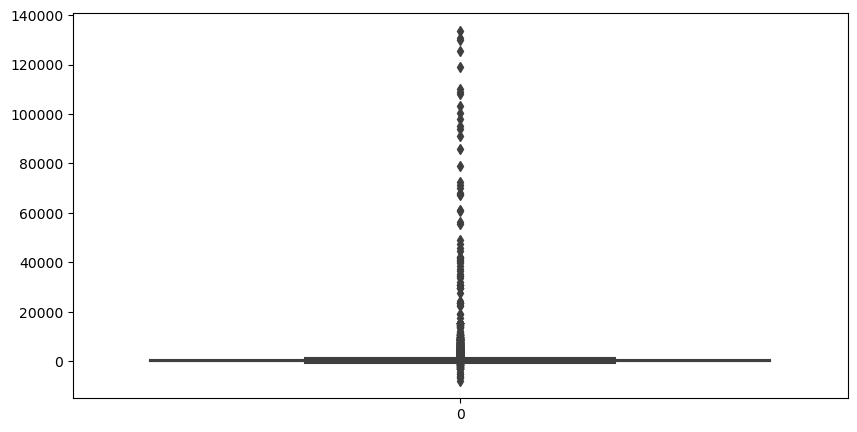

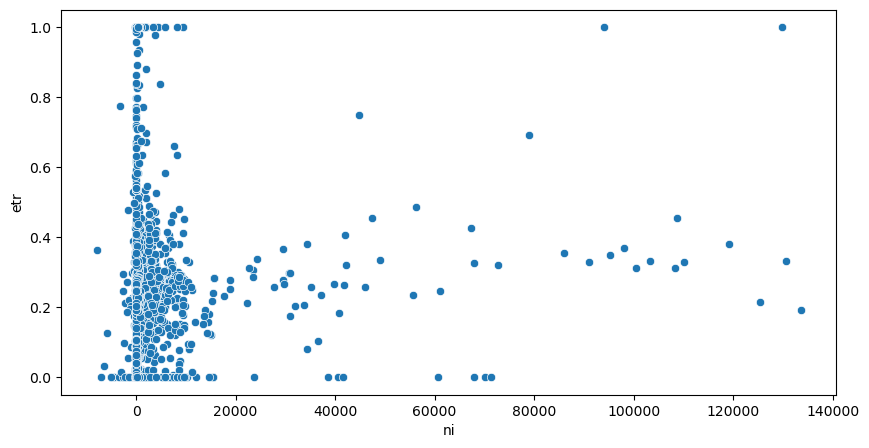

In [166]:
quick_viz(df.ni)

In [167]:
df["ni_profit"] = np.where(df.ni > 0, 1, 0)
df_test["ni_profit"] = np.where(df_test.ni > 0, 1, 0)

df["ni_profit_20000"] = np.where(df.ni > 20000, 1, 0)
df_test["ni_profit_20000"] = np.where(df_test.ni > 20000, 1, 0)

In [168]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 72) (363, 72)
True


**ppent** - let's apply sqrt here

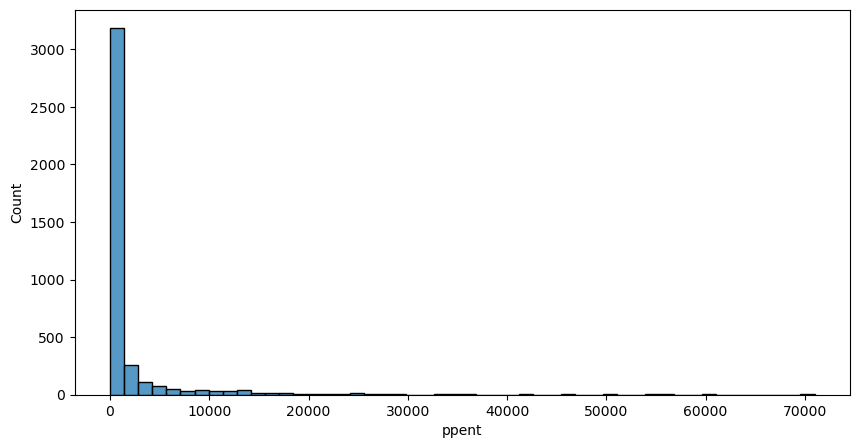

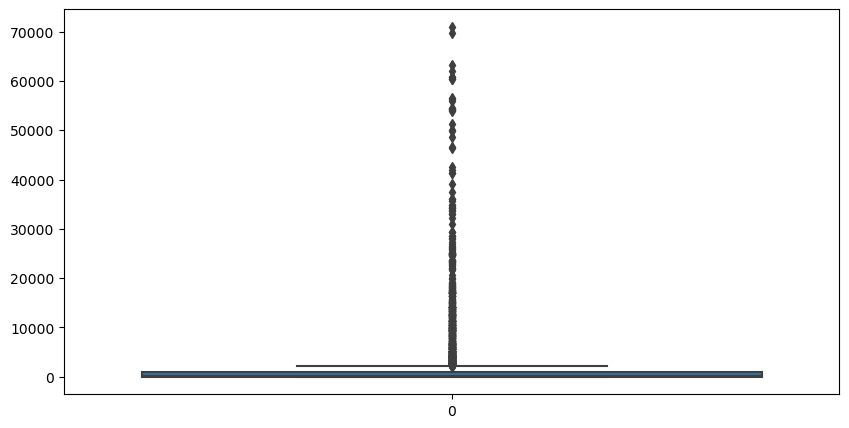

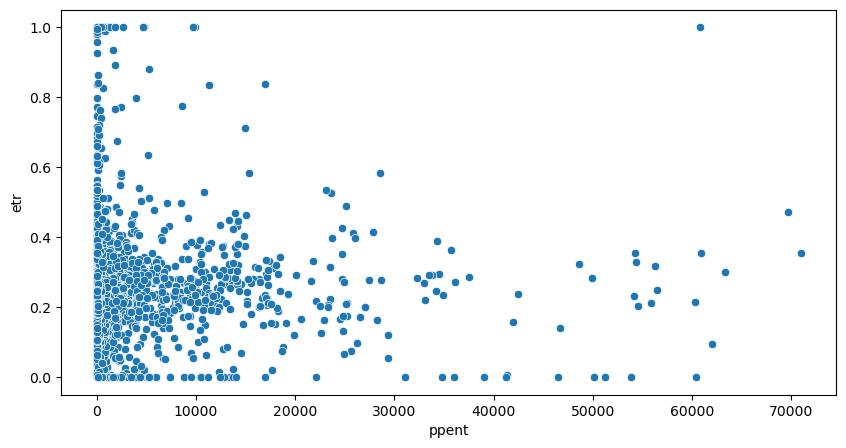

In [169]:
quick_viz(df.ppent)

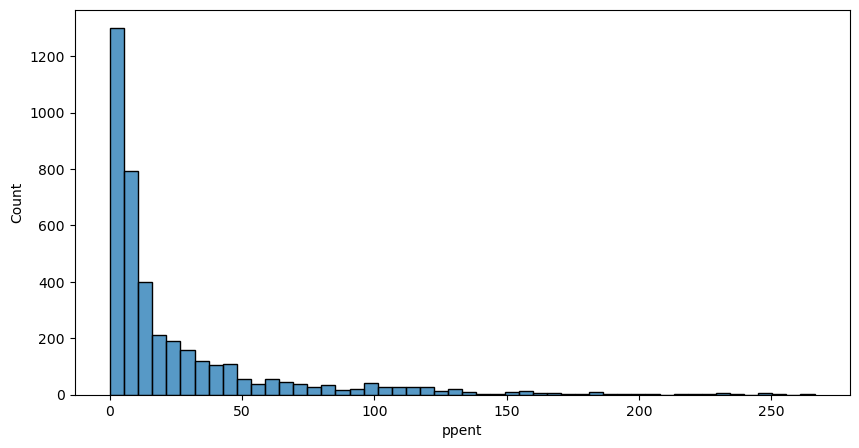

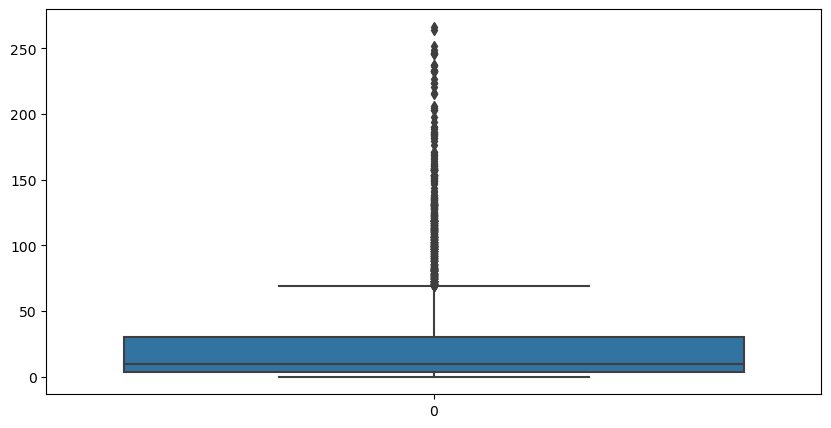

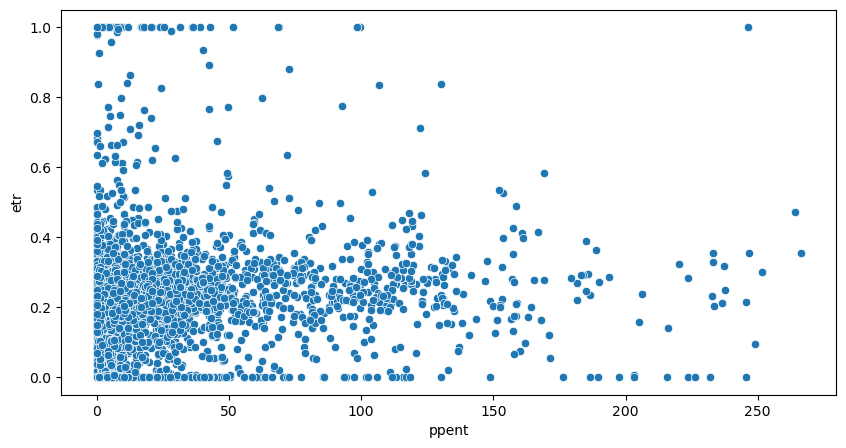

In [170]:
quick_viz(np.sqrt(df.ppent))

In [171]:
df["ppent_sqrt"] = np.sqrt(df.ppent)
df_test["ppent_sqrt"] = np.sqrt(df_test.ppent)

In [172]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 73) (363, 73)
True


**intant** - sqrt

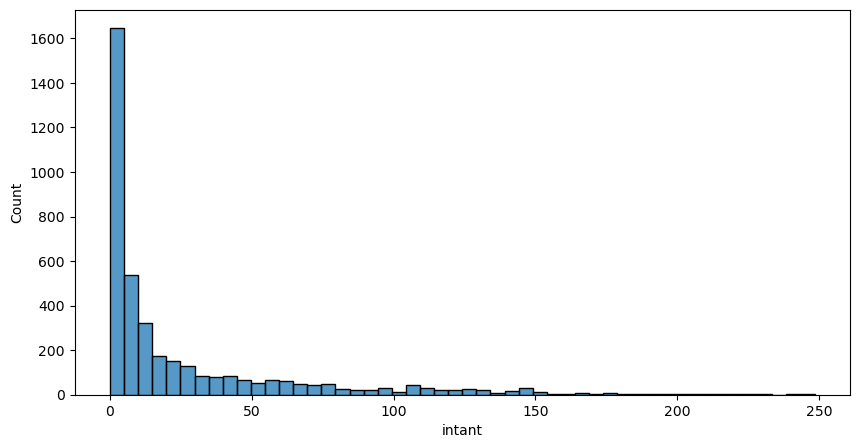

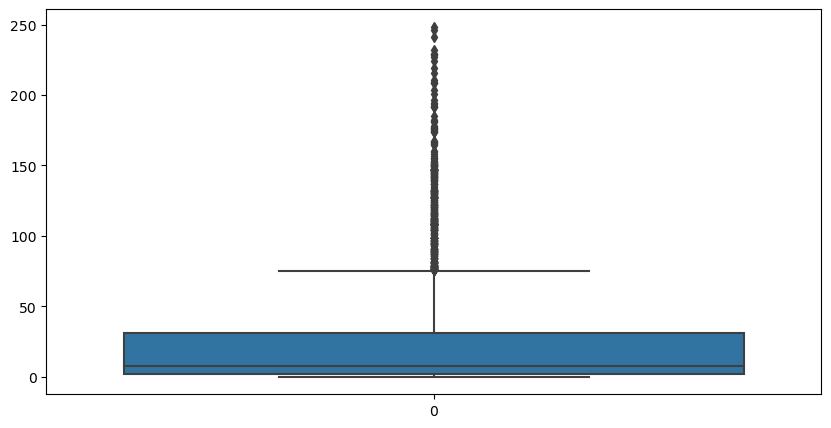

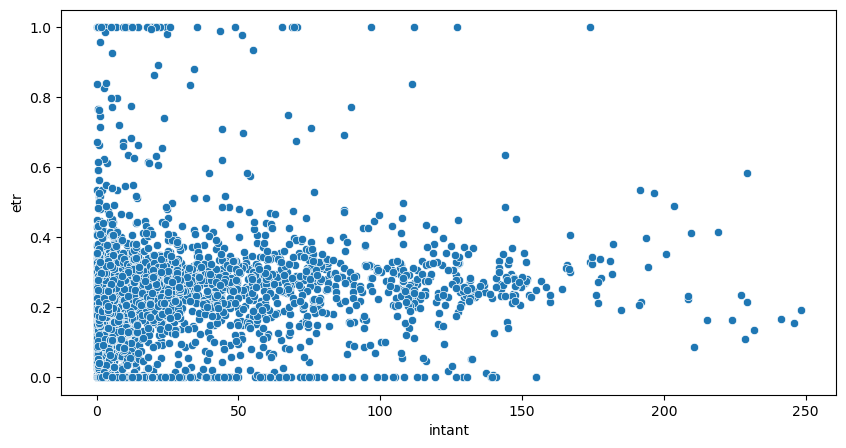

In [173]:
quick_viz(np.sqrt(df.intant))

In [174]:
df["intant_sqrt"] = np.sqrt(df.intant)
df_test["intant_sqrt"] = np.sqrt(df_test.intant)

In [175]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 74) (363, 74)
True


**dlc** - discretization using tree

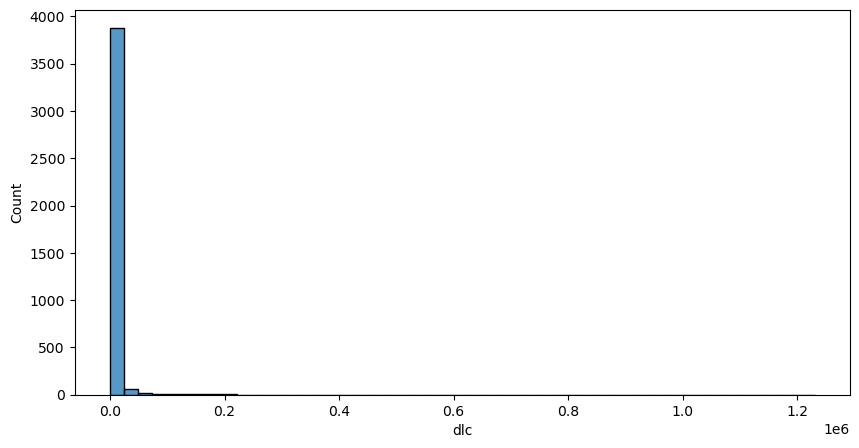

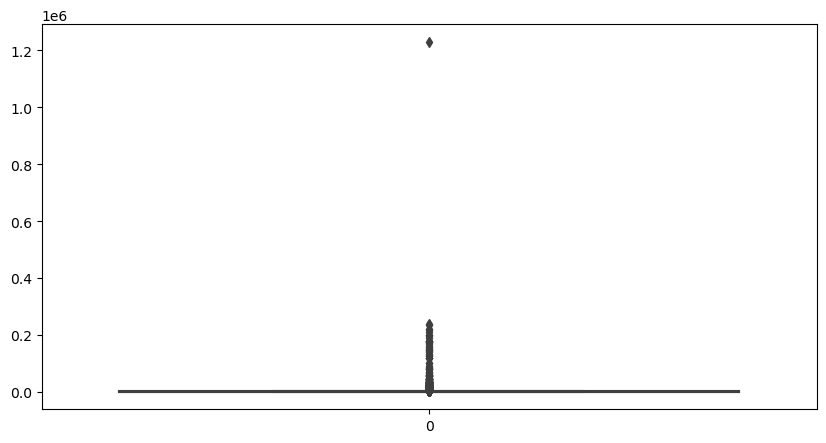

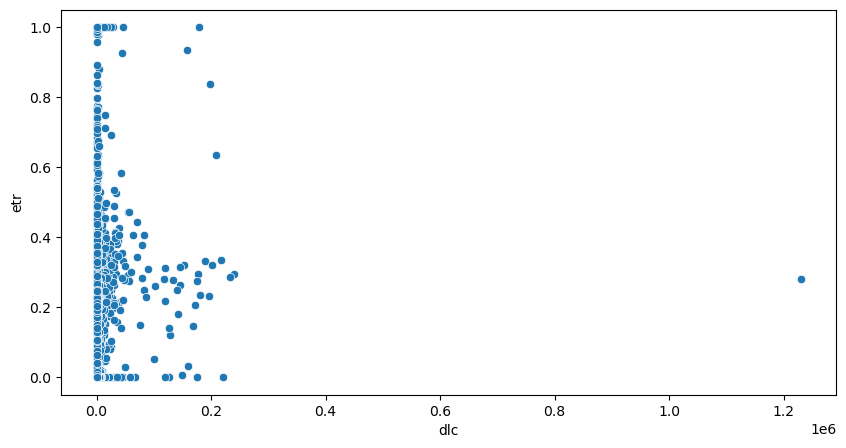

In [176]:
quick_viz(df.dlc)

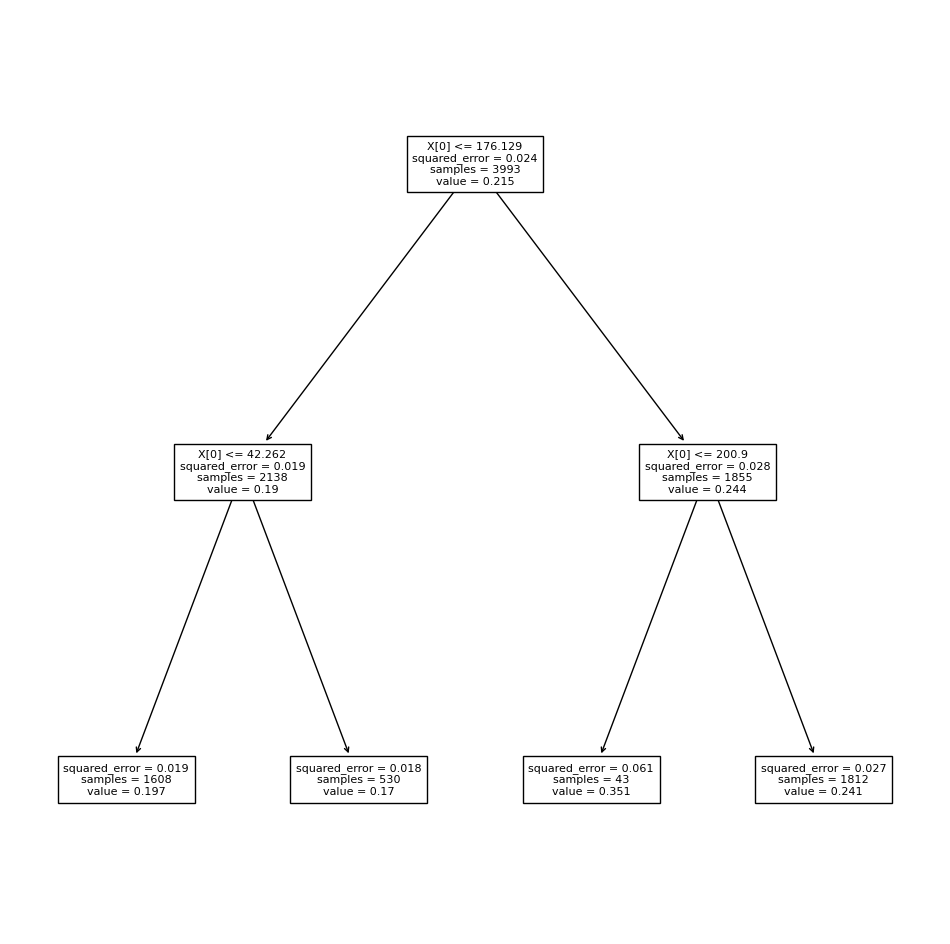

In [177]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["dlc"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [178]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [179]:
df["dlc_cat"] = pd.cut(df["dlc"], splits)
df_test["dlc_cat"] = pd.cut(df_test["dlc"], splits)

In [180]:
df = pd.get_dummies(df, columns=["dlc_cat"], prefix=["dlc_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["dlc_cat"], prefix=["dlc_cat"], drop_first=True
)

In [181]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 77) (363, 77)
True


**dltt** - discretization using tree

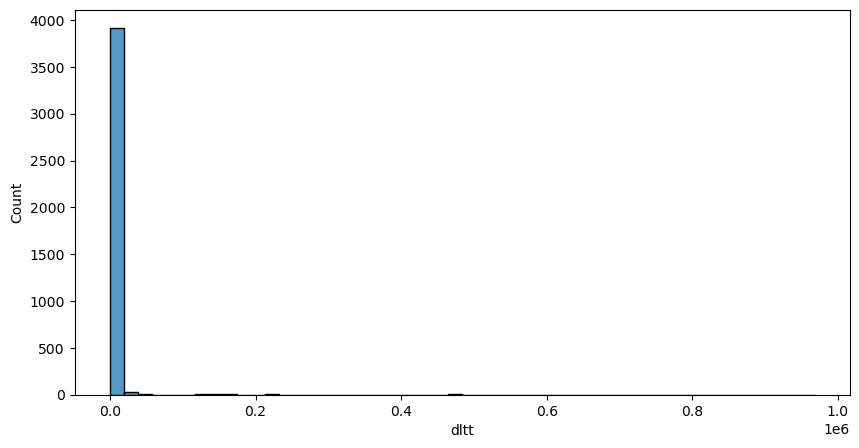

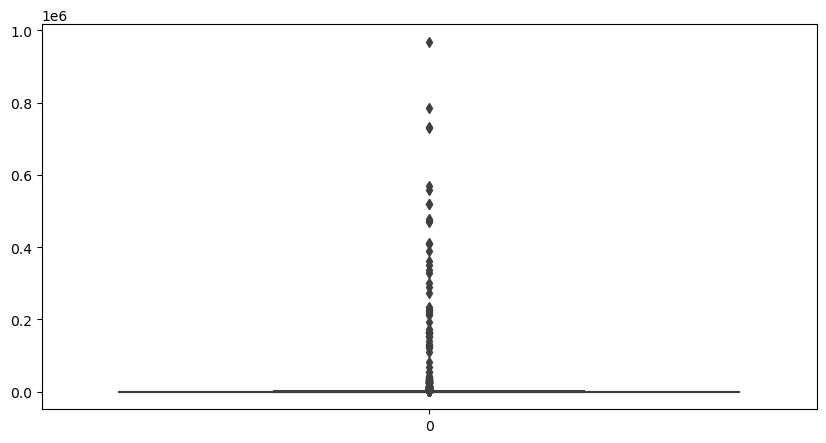

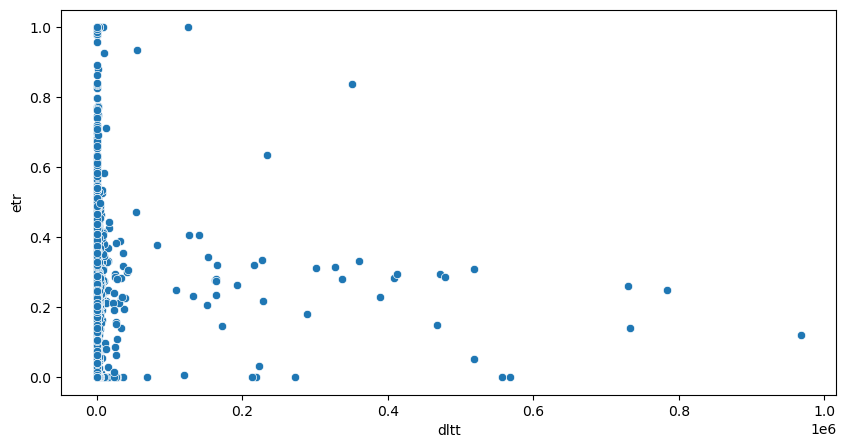

In [182]:
quick_viz(df.dltt)

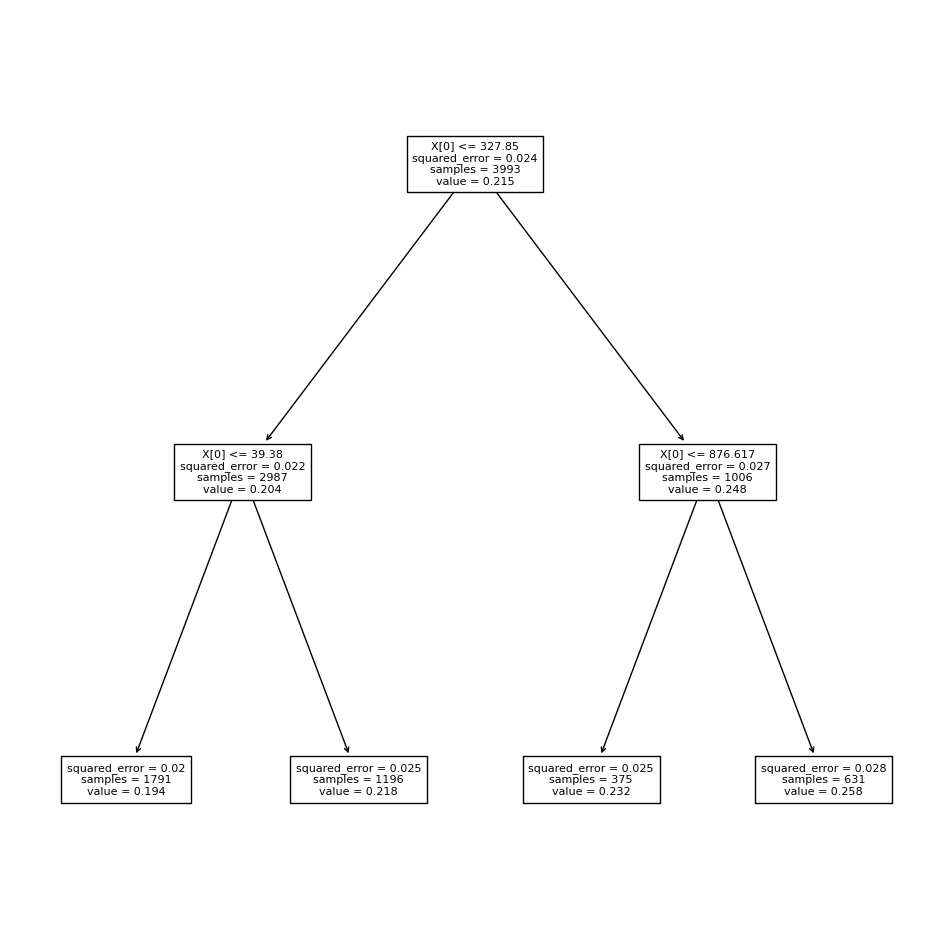

In [183]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["dltt"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [184]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [185]:
df["dltt_cat"] = pd.cut(df["dltt"], splits)
df_test["dltt_cat"] = pd.cut(df_test["dltt"], splits)

df = pd.get_dummies(df, columns=["dltt_cat"], prefix=["dltt_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["dltt_cat"], prefix=["dltt_cat"], drop_first=True
)

In [186]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 80) (363, 80)
True


**capex** - discretization using tree

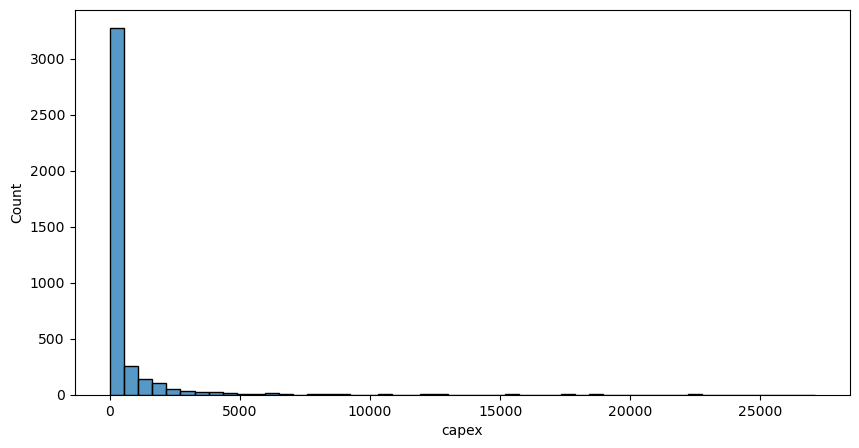

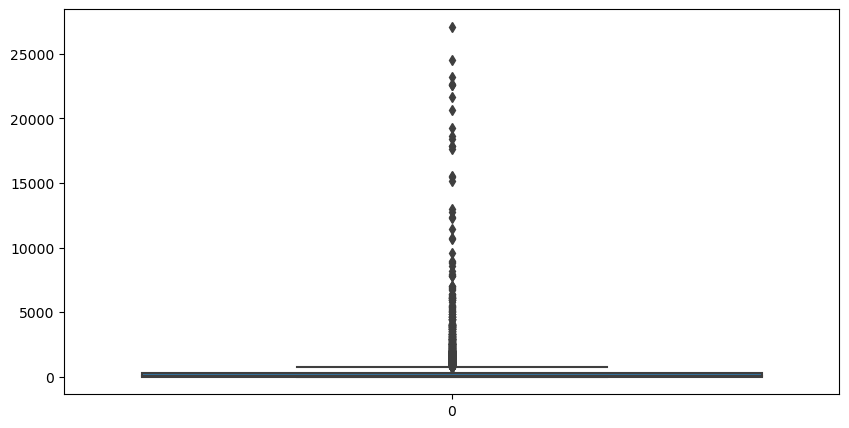

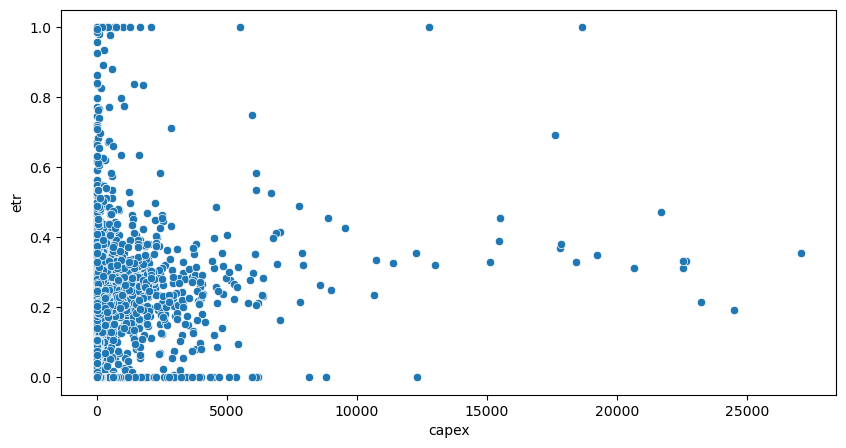

In [187]:
quick_viz(df.capex)

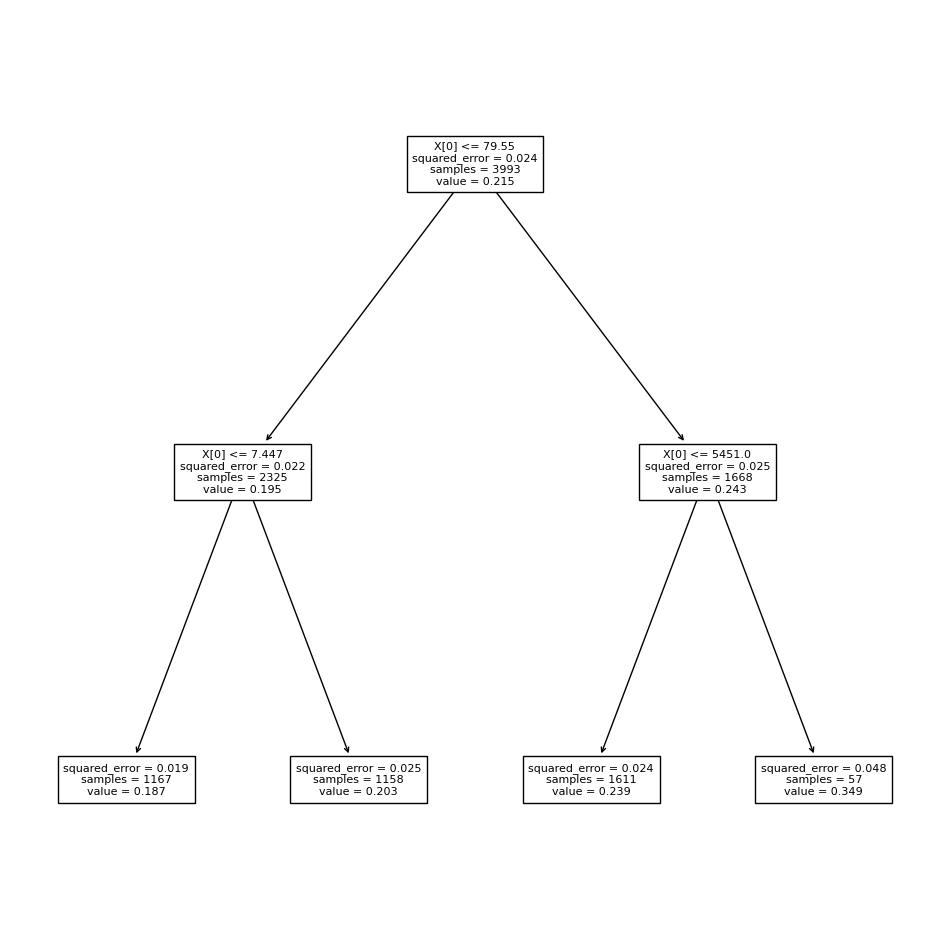

In [188]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["capex"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [189]:
df["capex_cat"] = pd.cut(df["capex"], splits)
df_test["capex_cat"] = pd.cut(df_test["capex"], splits)

df = pd.get_dummies(df, columns=["capex_cat"], prefix=["capex_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["capex_cat"], prefix=["capex_cat"], drop_first=True
)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 83) (363, 83)
True


**revenue** - discretization using tree

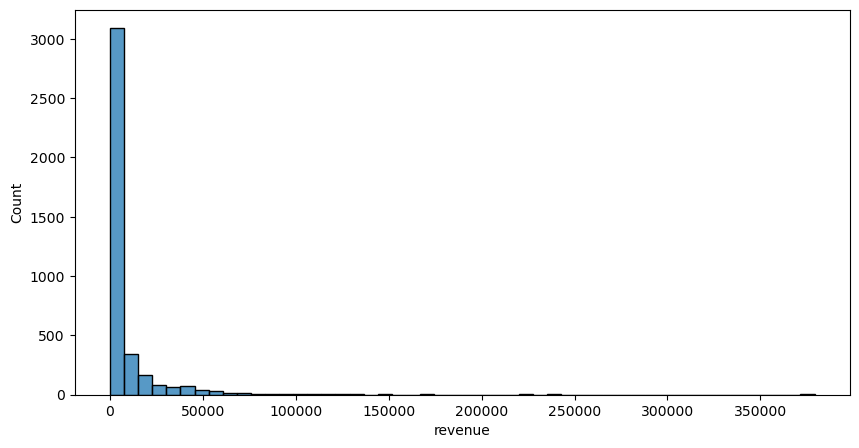

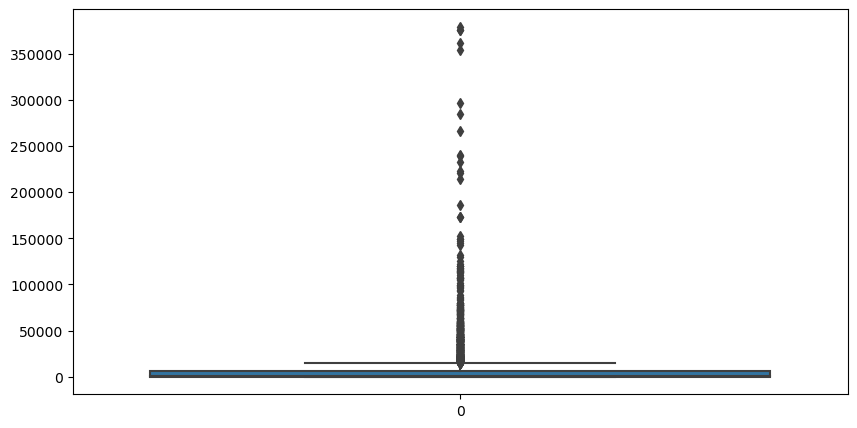

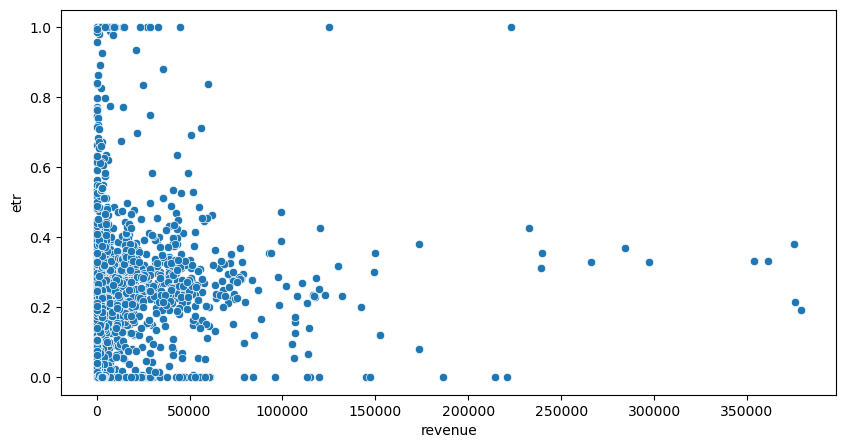

In [190]:
quick_viz(df.revenue)

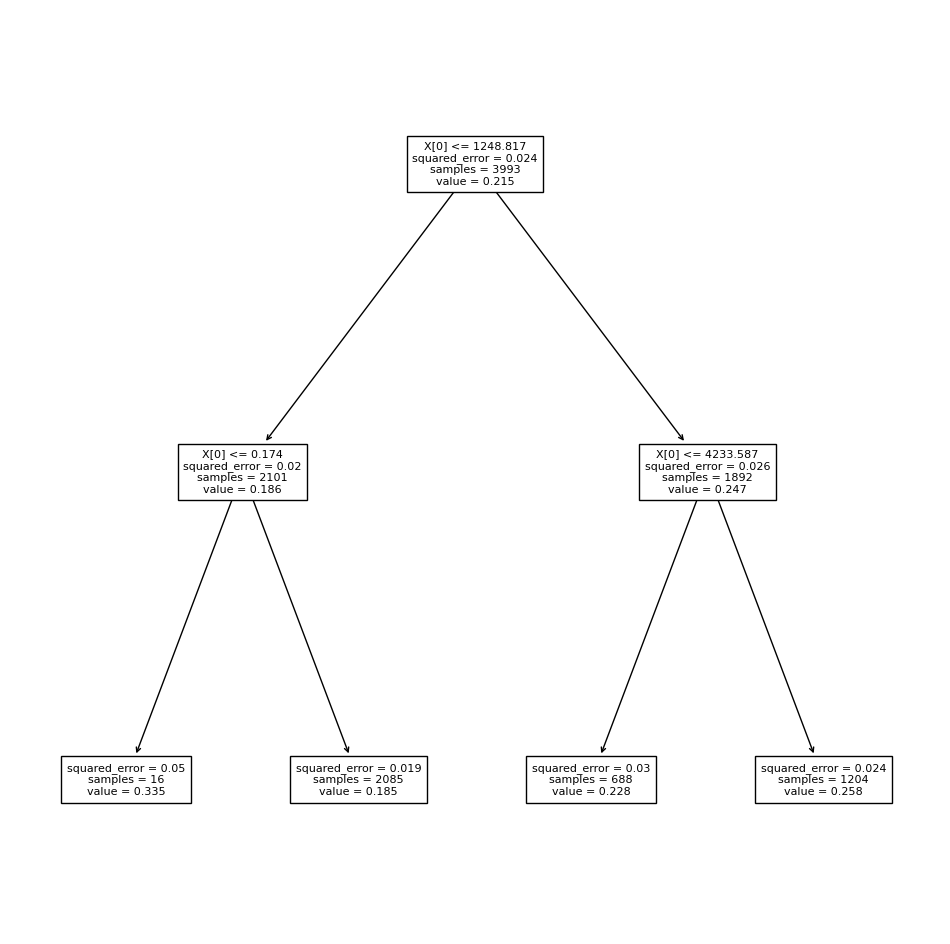

In [191]:
clf = tree.DecisionTreeRegressor(
    max_depth=2,
)
clf = clf.fit(np.array(df["revenue"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [192]:
df["revenue_cat"] = pd.cut(df["revenue"], splits)
df_test["revenue_cat"] = pd.cut(df_test["revenue"], splits)

df = pd.get_dummies(
    df, columns=["revenue_cat"], prefix=["revenue_cat"], drop_first=True
)
df_test = pd.get_dummies(
    df_test, columns=["revenue_cat"], prefix=["revenue_cat"], drop_first=True
)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 86) (363, 86)
True


**cce** - let's use decision tree

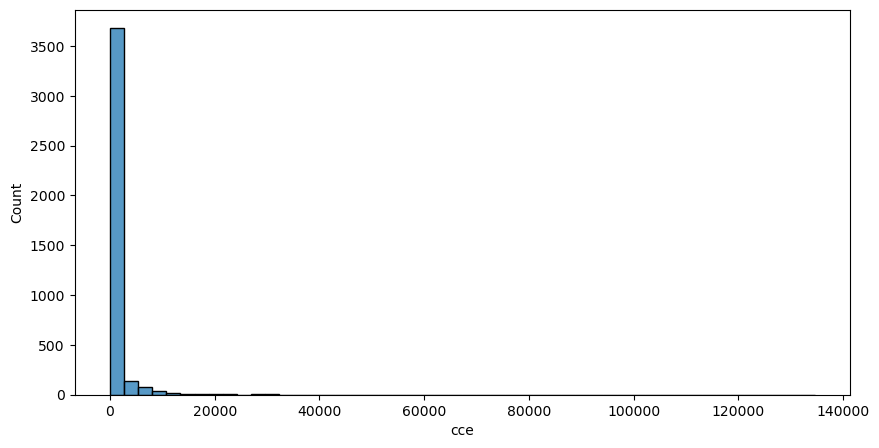

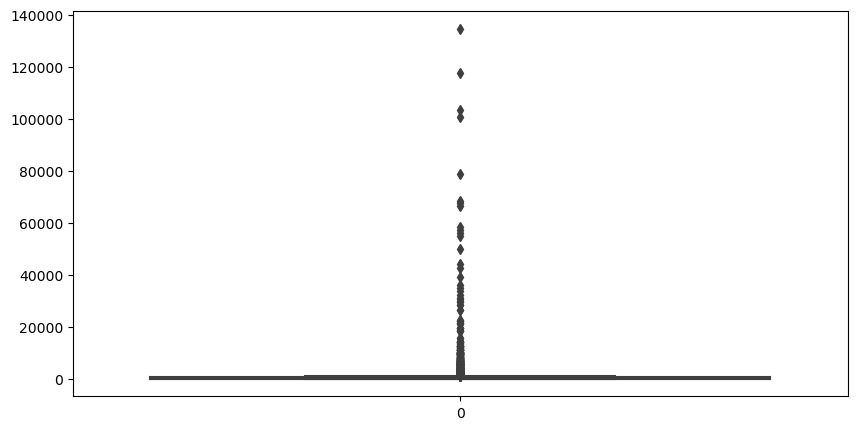

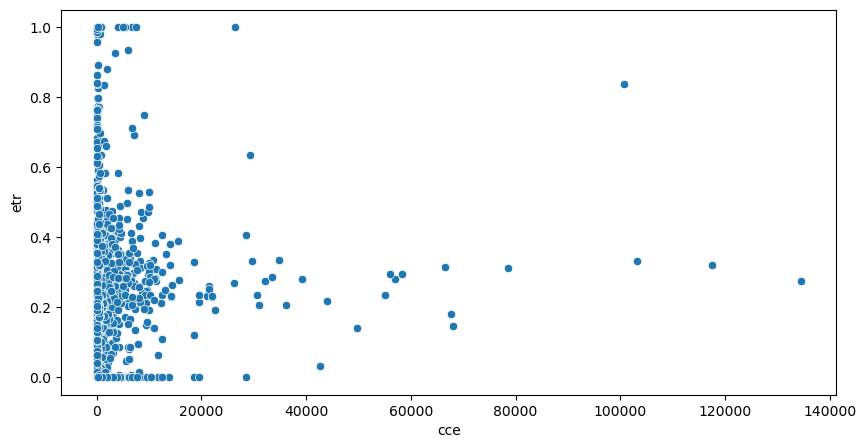

In [193]:
quick_viz(df.cce)

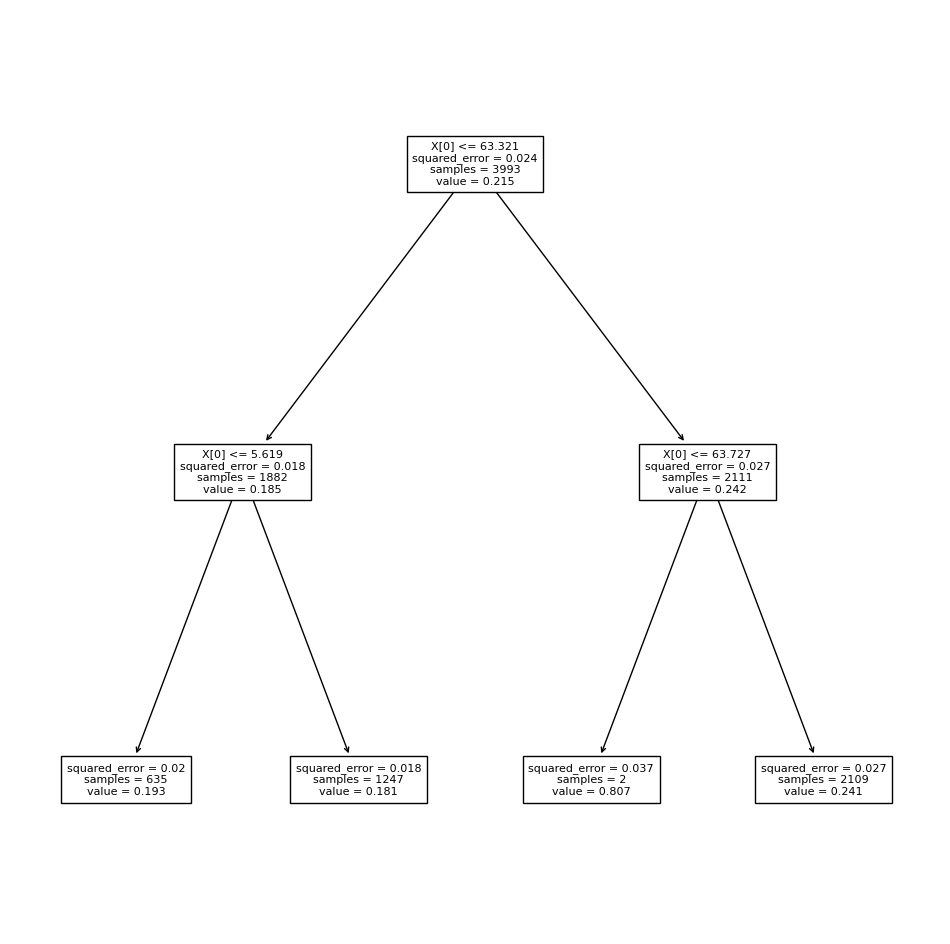

In [194]:
clf = tree.DecisionTreeRegressor(
    max_depth=2,
)
clf = clf.fit(np.array(df["cce"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [195]:
splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)

In [196]:
splits.remove(63.72700119018555)

In [197]:
splits.sort()

In [198]:
df["cce_cat"] = pd.cut(df["cce"], splits)
df_test["cce_cat"] = pd.cut(df_test["cce"], splits)

df = pd.get_dummies(df, columns=["cce_cat"], prefix=["cce_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["cce_cat"], prefix=["cce_cat"], drop_first=True
)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 88) (363, 88)
True


**adv** - let's use decision tree

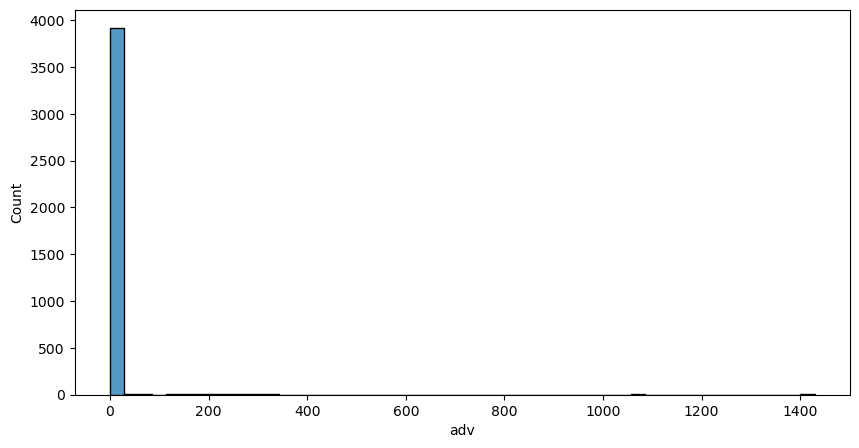

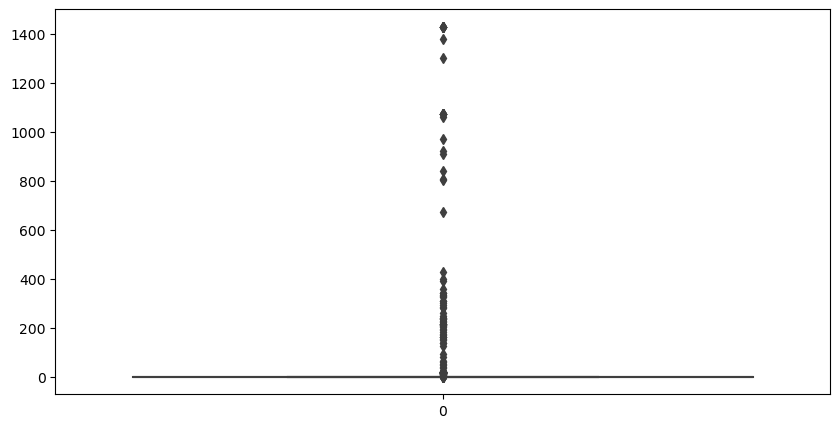

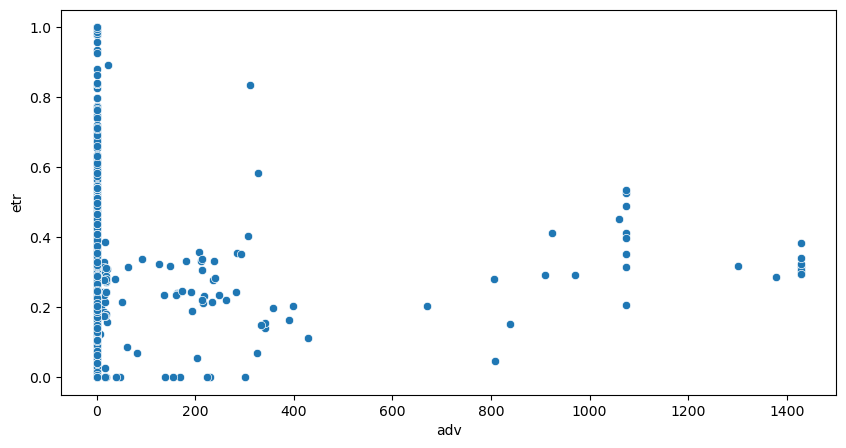

In [199]:
quick_viz(df.adv)

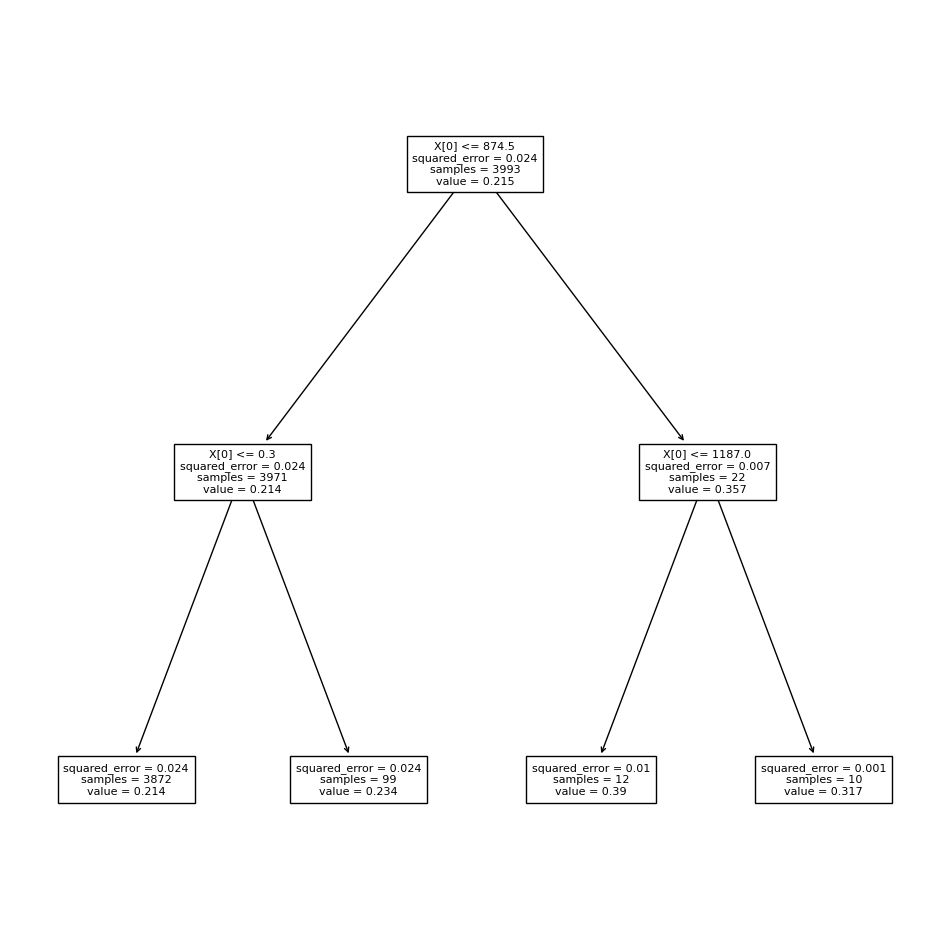

In [200]:
clf = tree.DecisionTreeRegressor(
    max_depth=2,
)
clf = clf.fit(np.array(df["adv"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

plt.figure(figsize=(12, 12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [201]:
splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)

In [202]:
splits.remove(1187.0)

In [203]:
splits.sort()

In [204]:
df["adv_cat"] = pd.cut(df["adv"], splits)
df_test["adv_cat"] = pd.cut(df_test["adv"], splits)

df = pd.get_dummies(df, columns=["adv_cat"], prefix=["adv_cat"], drop_first=True)
df_test = pd.get_dummies(
    df_test, columns=["adv_cat"], prefix=["adv_cat"], drop_first=True
)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 90) (363, 90)
True


**diff** - greater or lower than zero - dichotomous variable

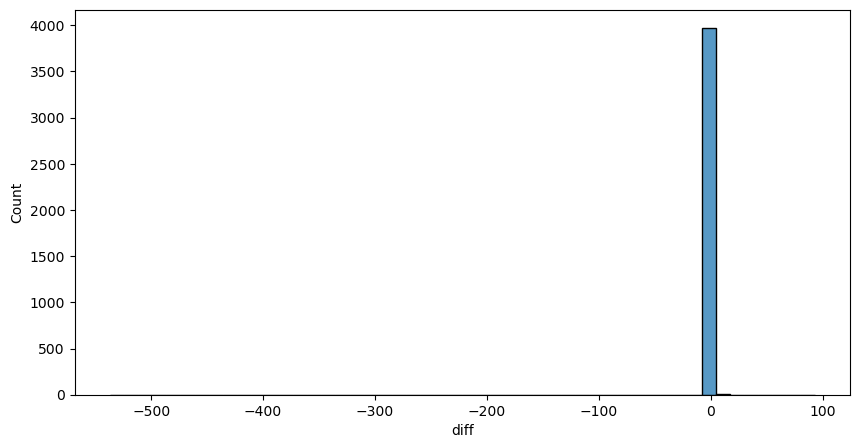

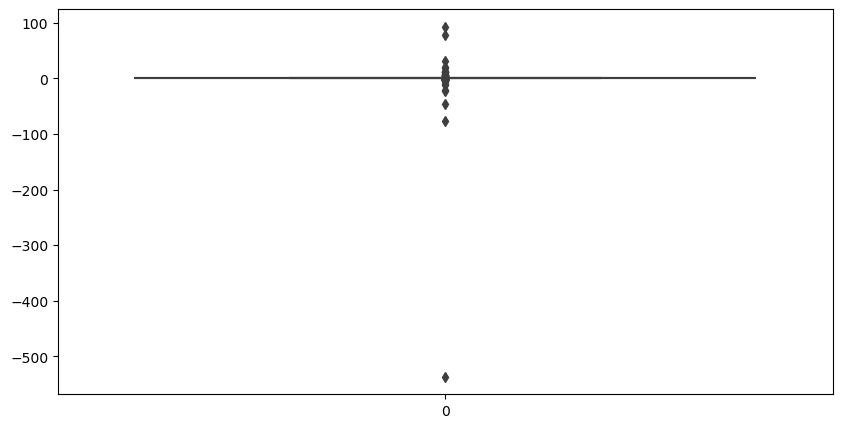

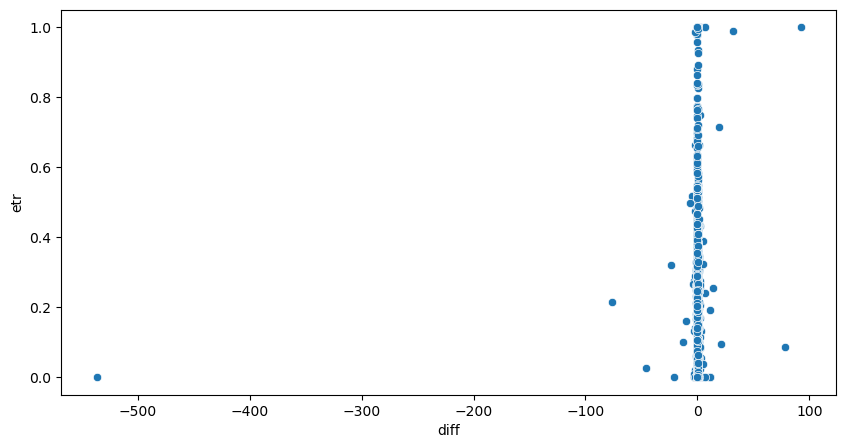

In [205]:
quick_viz(df["diff"])

In [206]:
df["diff_positive"] = np.where(df["diff"] >= 0, 1, 0)
df_test["diff_positive"] = np.where(df_test["diff"] >= 0, 1, 0)

In [207]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 91) (363, 91)
True


**roa** - clipping

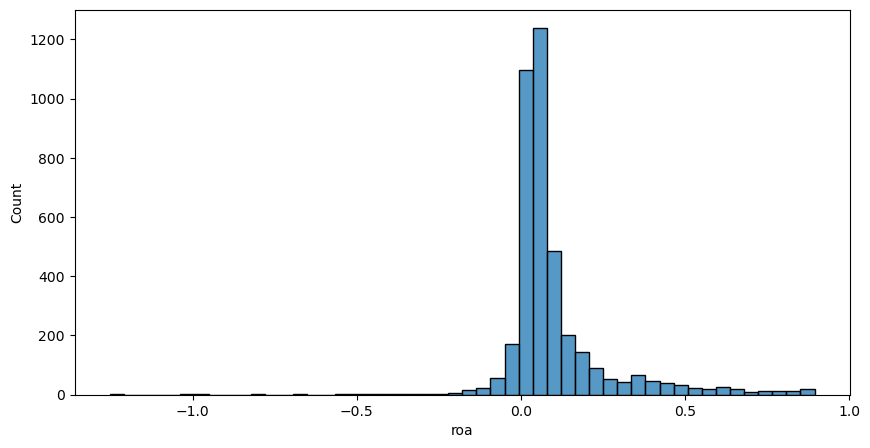

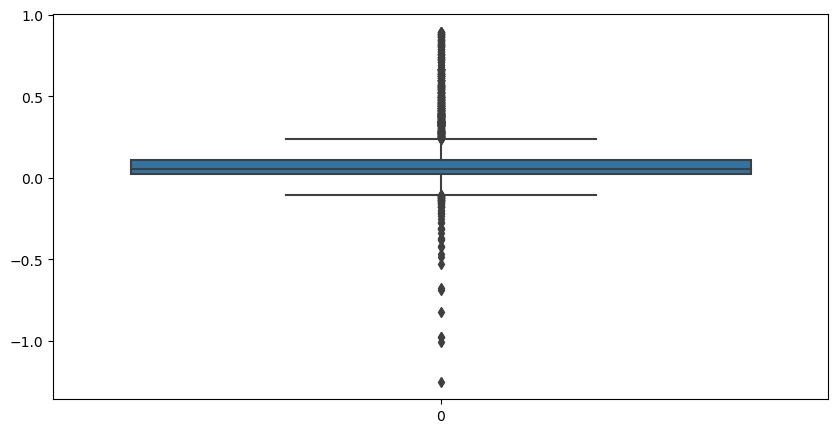

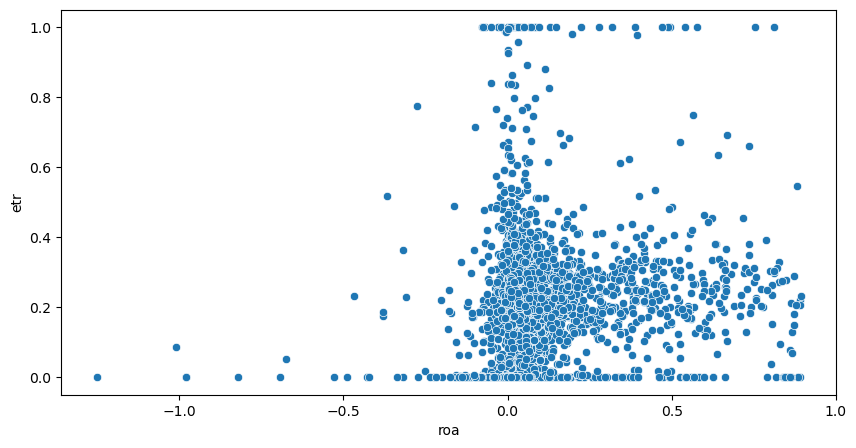

In [208]:
quick_viz(df.roa)

In [209]:
df["roa_clip"] = df.roa.clip(lower=-1)
df_test["roa_clip"] = df_test.roa.clip(lower=-1)

In [210]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 92) (363, 92)
True


**lev** - sqrt

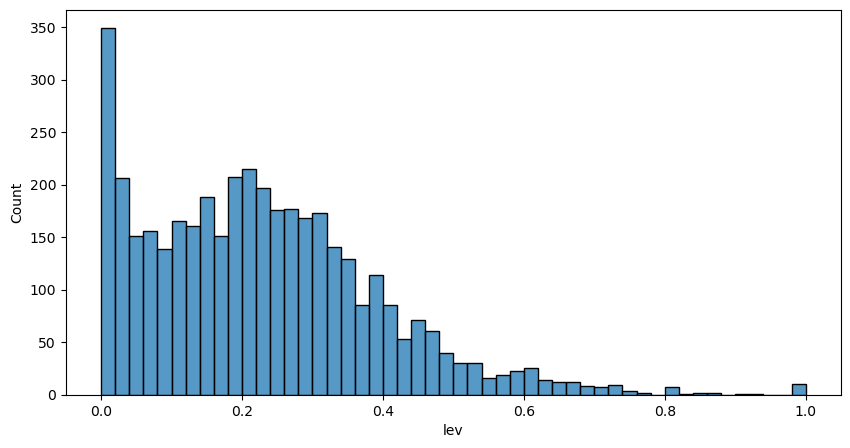

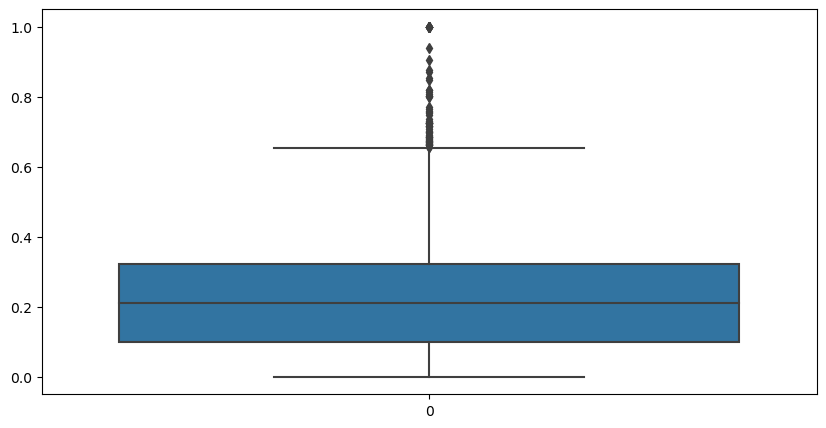

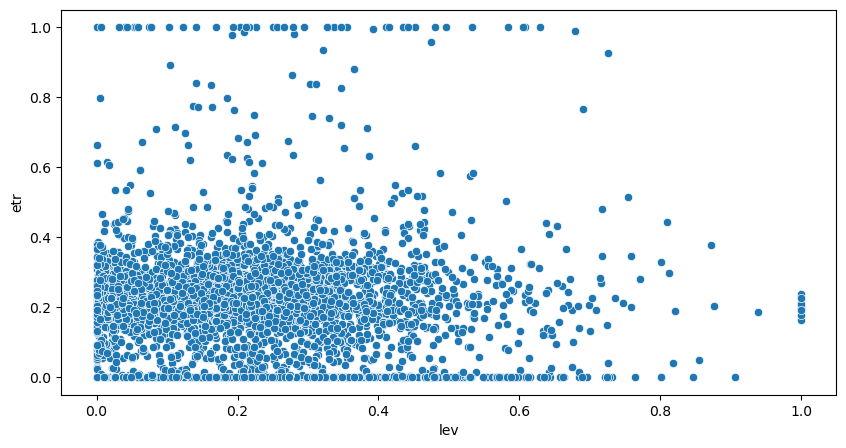

In [211]:
quick_viz(df.lev)

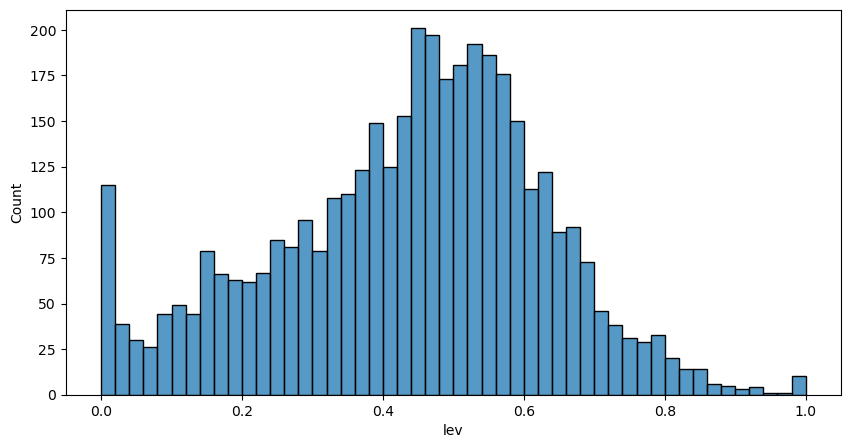

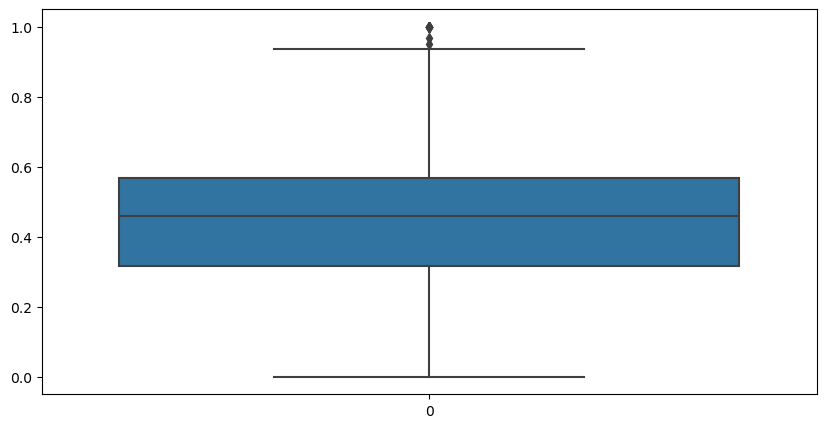

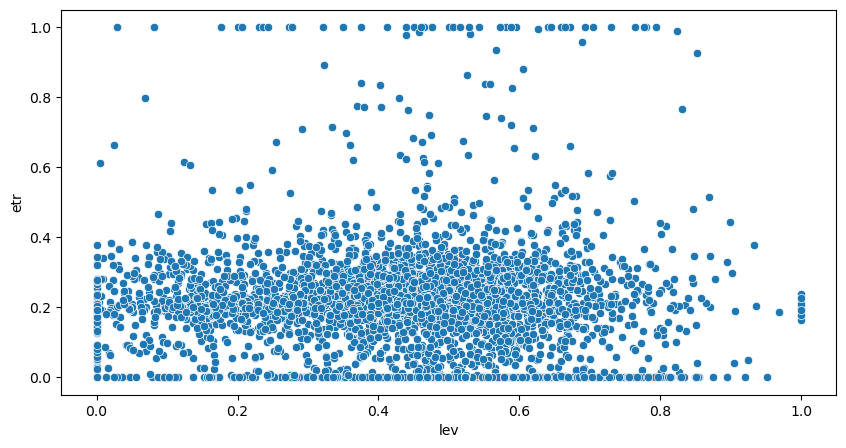

In [212]:
quick_viz(np.sqrt(df.lev))

In [213]:
df["lev_sqrt"] = np.sqrt(df.lev)
df_test["lev_sqrt"] = np.sqrt(df_test.lev)

In [214]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 93) (363, 93)
True


**intan** - pow

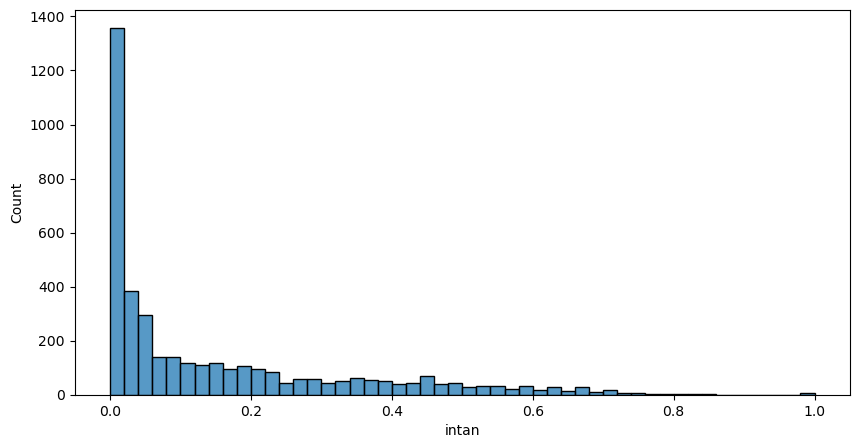

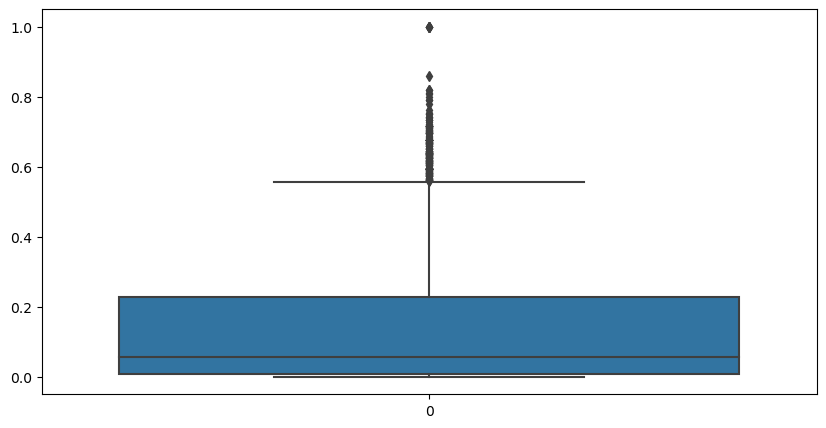

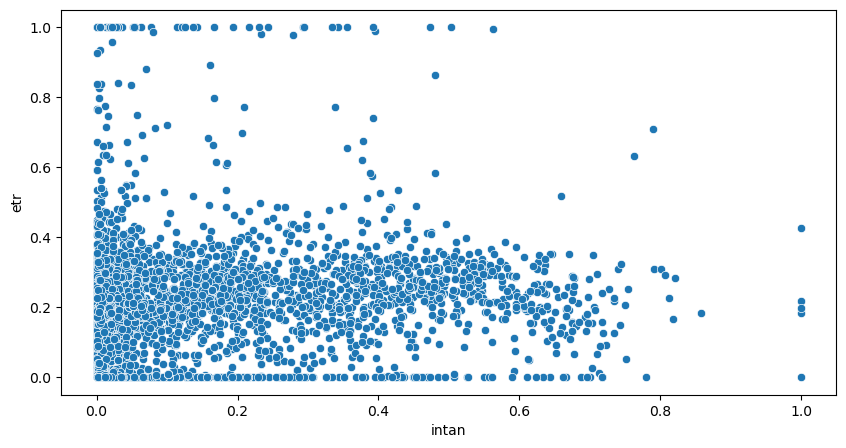

In [215]:
quick_viz(df.intan)

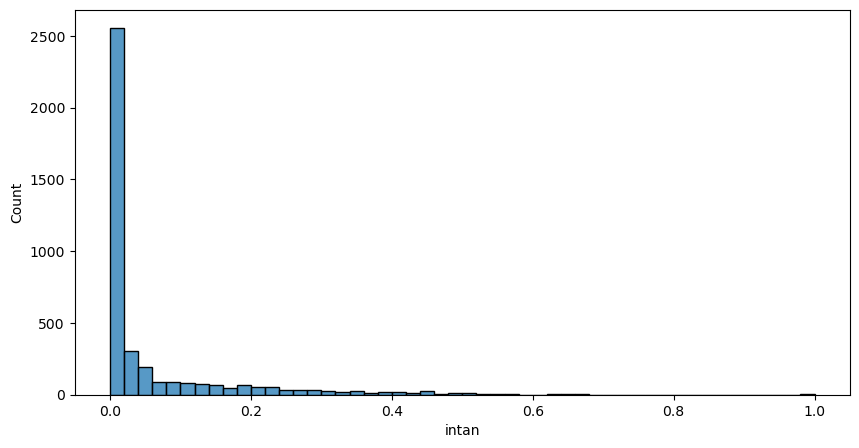

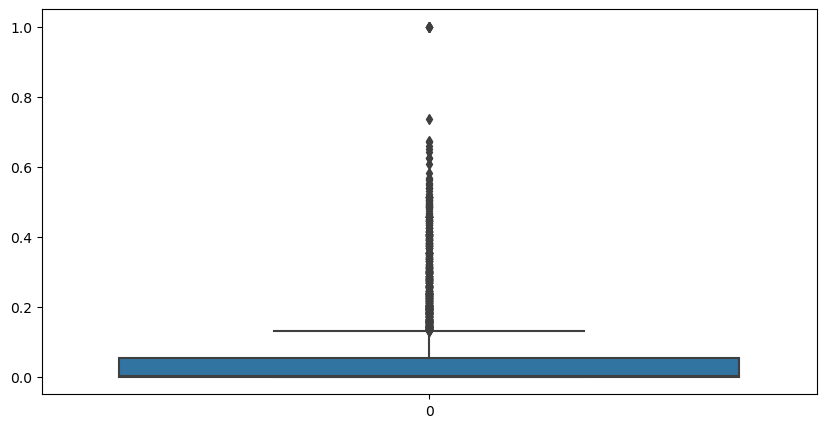

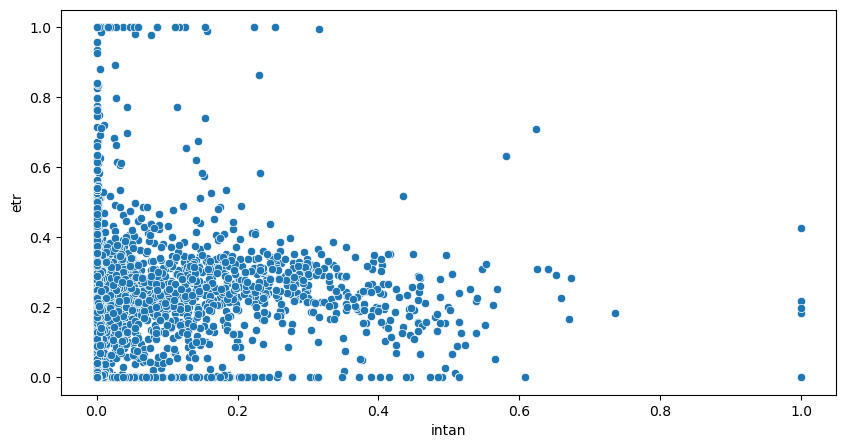

In [216]:
quick_viz(np.power(df.intan, 2))

In [217]:
df["intan_pow2"] = np.power(df.intan, 2)
df_test["intan_pow2"] = np.power(df_test.intan, 2)

In [218]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 94) (363, 94)
True


**rd** - sqrt

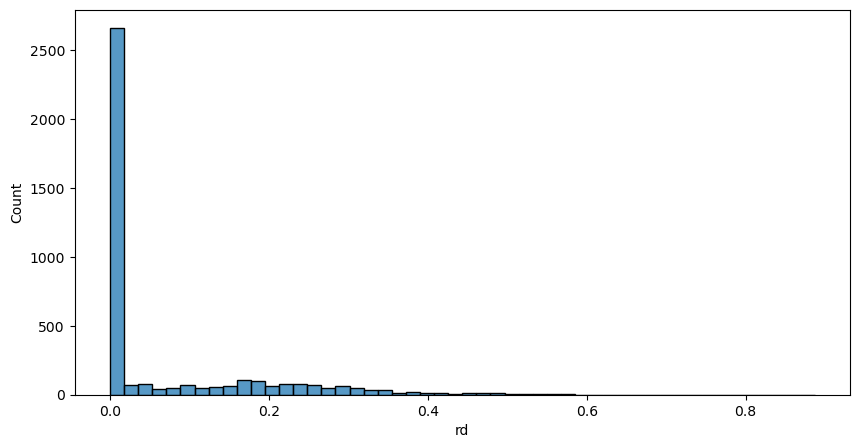

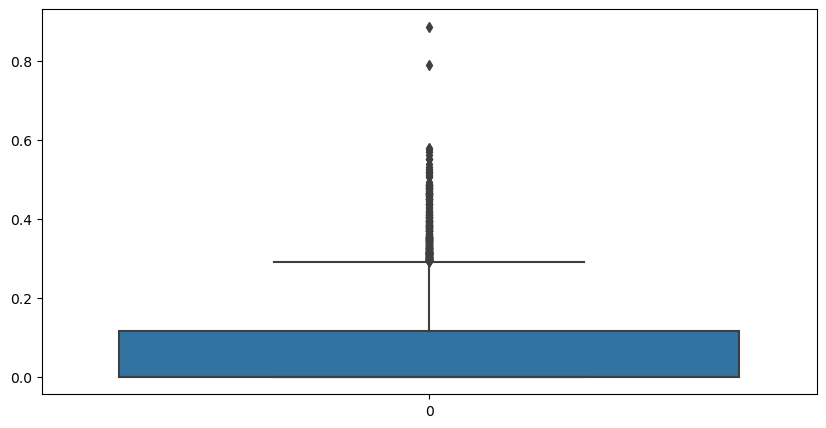

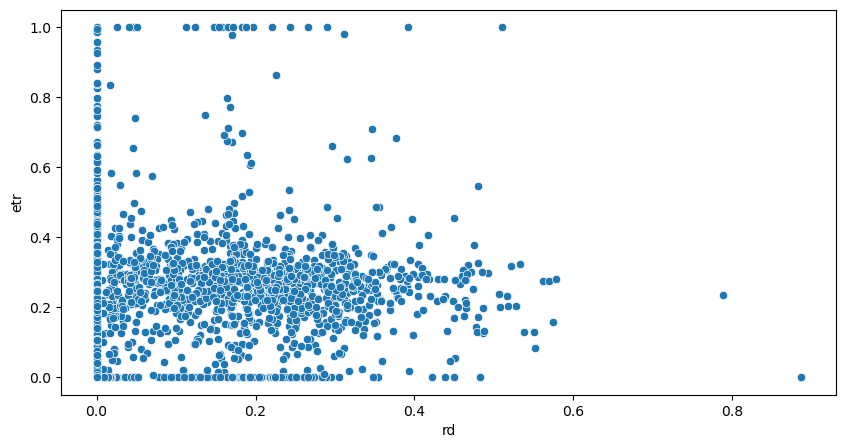

In [219]:
quick_viz(np.sqrt(df.rd))

In [220]:
df["rd_sqrt"] = np.power(df.rd, 0.5)
df_test["rd_sqrt"] = np.power(df_test.rd, 0.5)

In [221]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 95) (363, 95)
True


**ppe** - clip

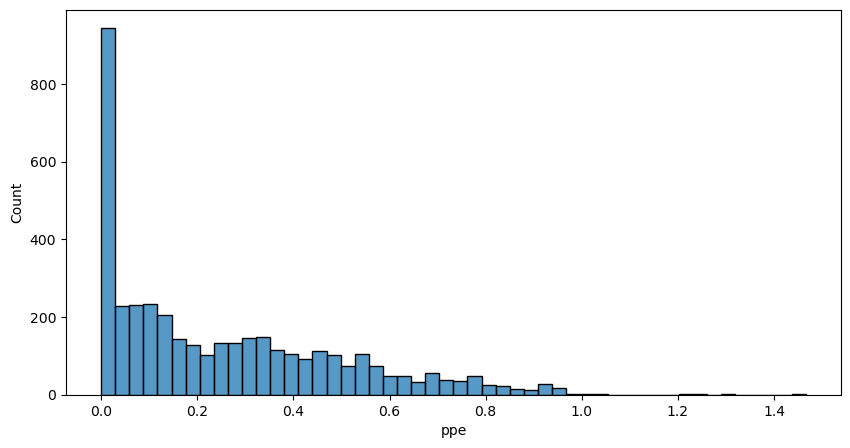

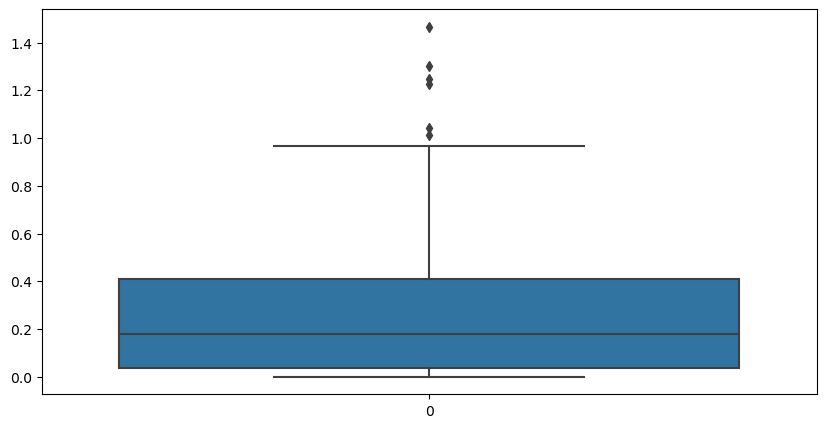

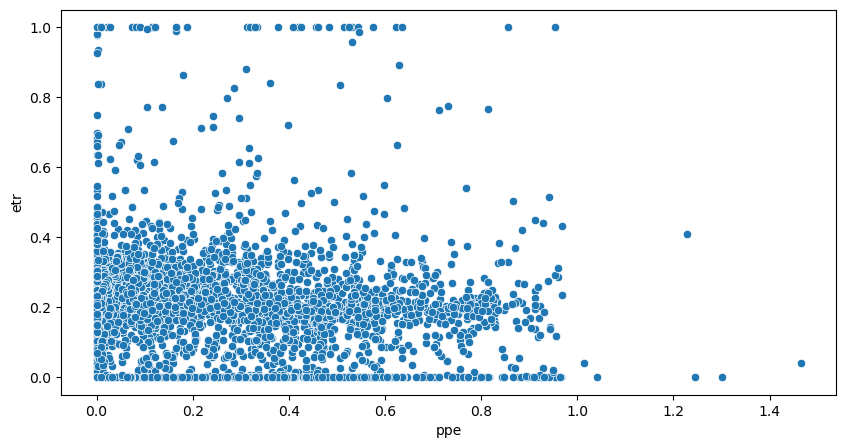

In [222]:
quick_viz(df.ppe)

In [223]:
df["ppe_clip"] = df.ppe.clip(upper=1)
df_test["ppe_clip"] = df_test.ppe.clip(upper=1)

In [224]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 96) (363, 96)
True


**sale**

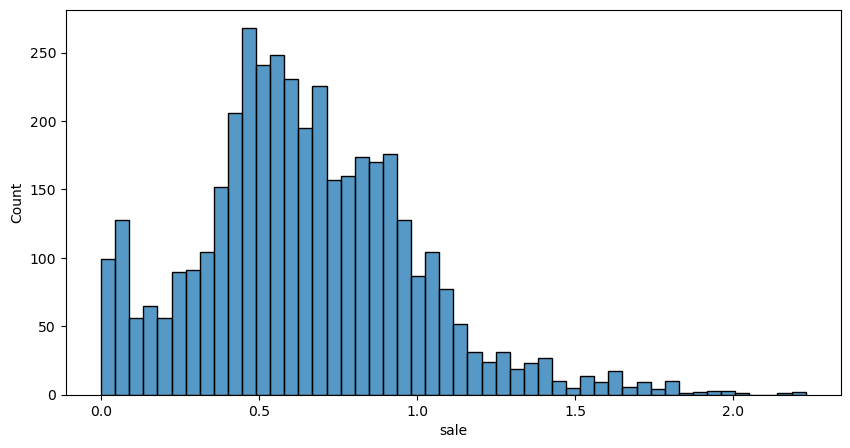

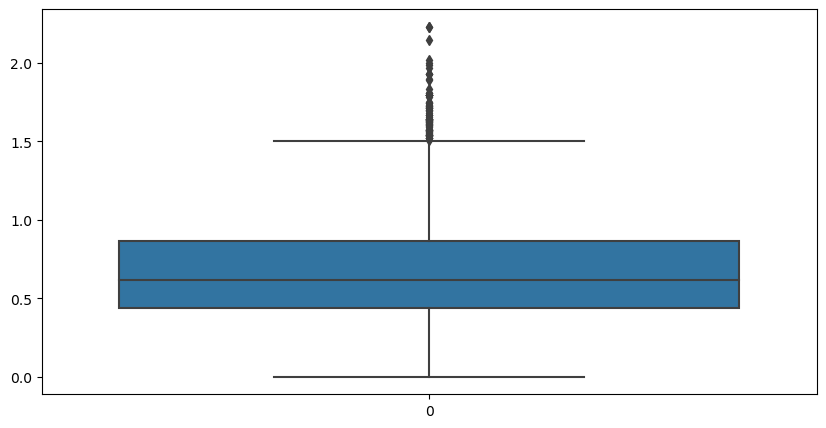

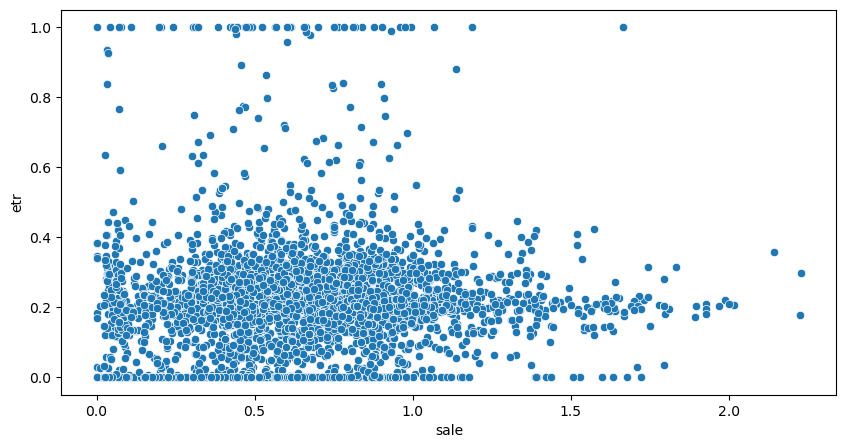

In [225]:
quick_viz(df.sale)

**cash_holdings** - sqrt

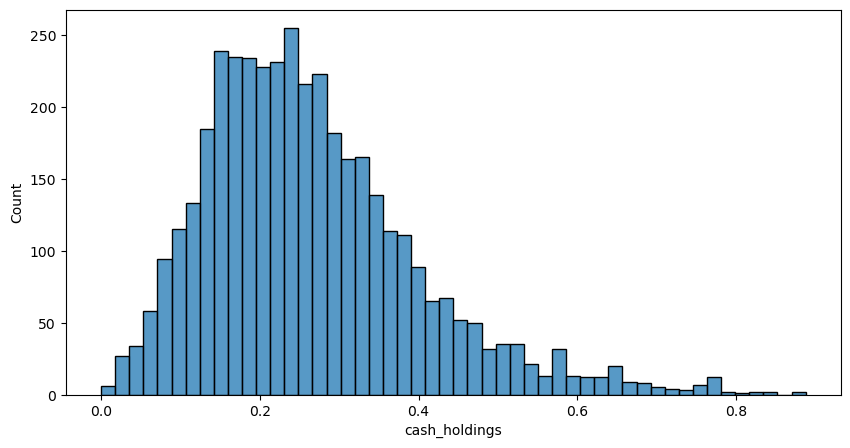

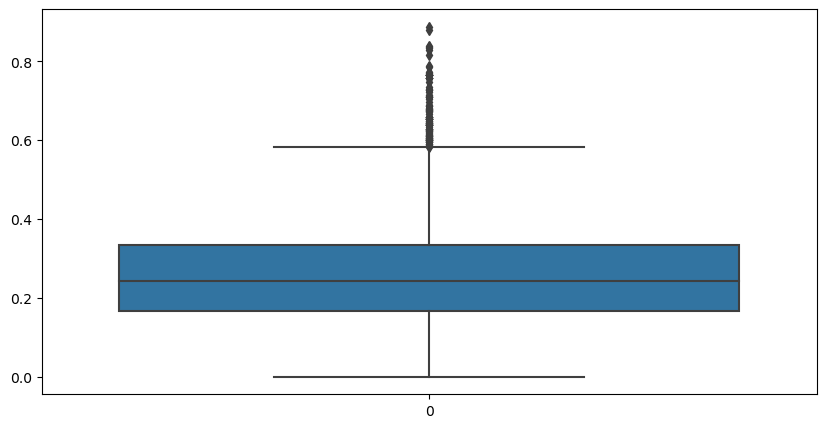

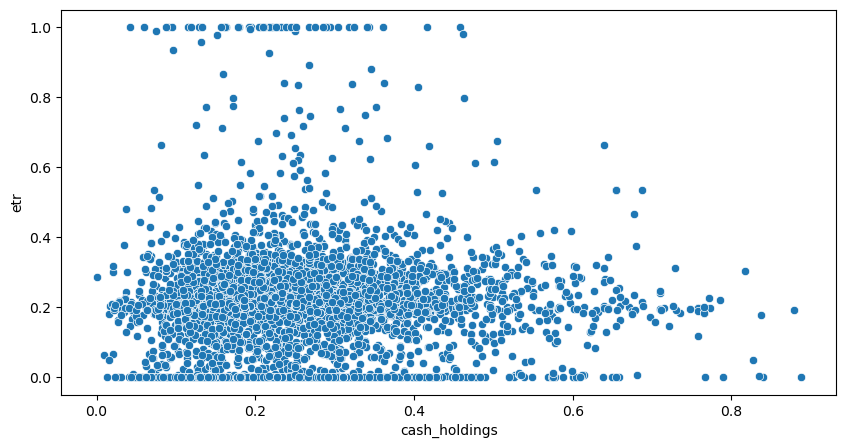

In [226]:
quick_viz(np.sqrt(df.cash_holdings))

In [227]:
df["cash_holdings_sqrt"] = np.sqrt(df.cash_holdings)
df_test["cash_holdings_sqrt"] = np.sqrt(df_test.cash_holdings)

In [228]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 97) (363, 97)
True


**adv_expenditures** - binary variable greater than 0 

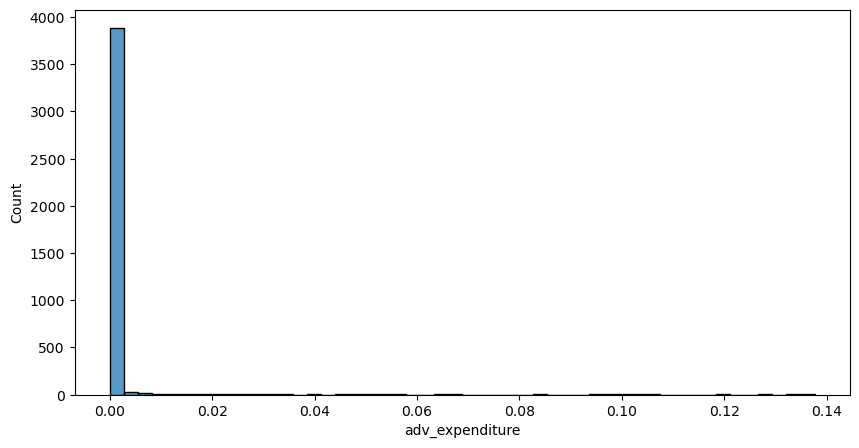

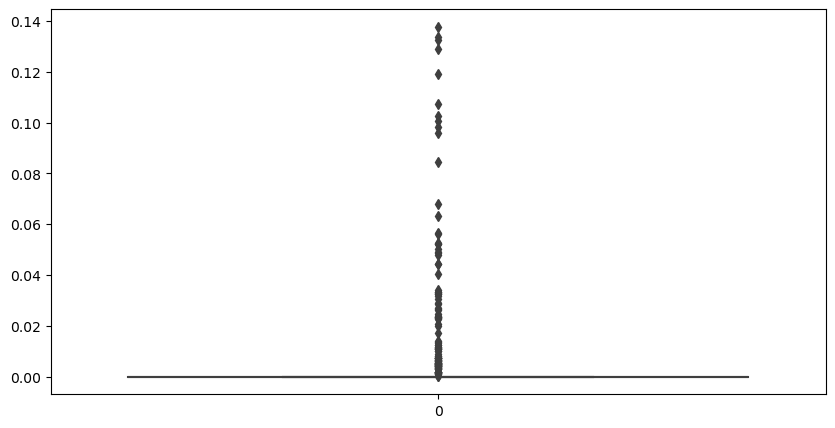

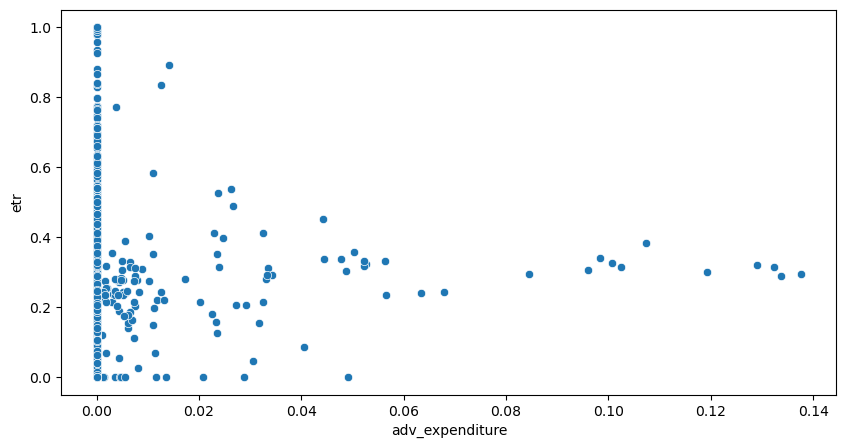

In [229]:
quick_viz(df.adv_expenditure)

In [230]:
df["adv_expenditure_positive"] = np.where(df.adv_expenditure > 0, 1, 0)
df_test["adv_expenditure_positive"] = np.where(df_test.adv_expenditure > 0, 1, 0)

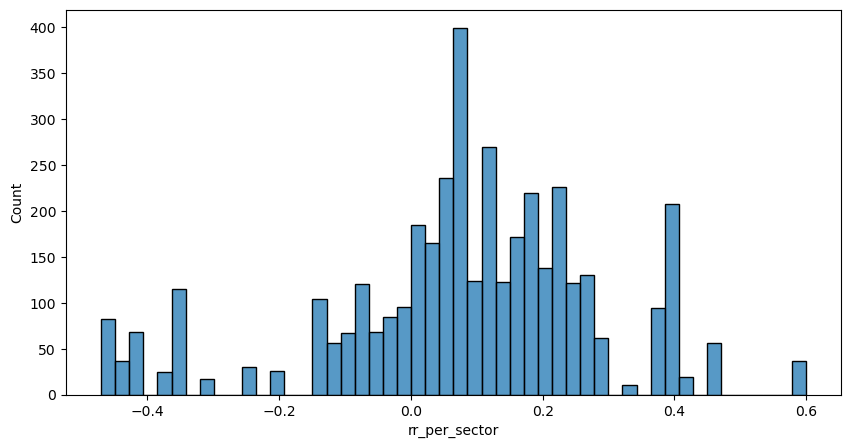

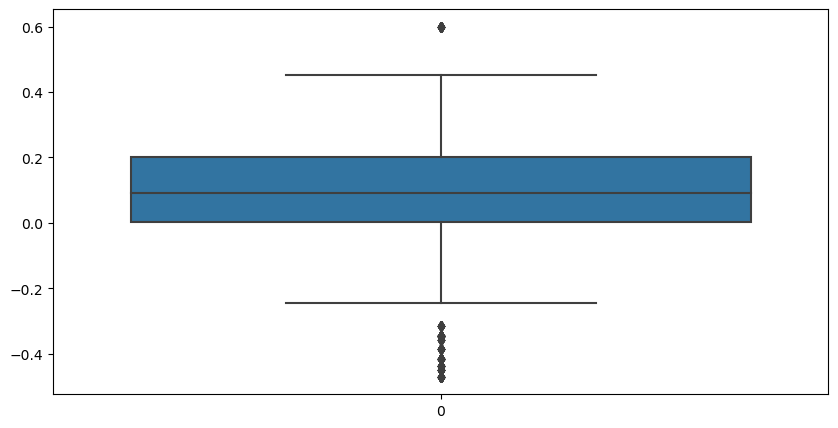

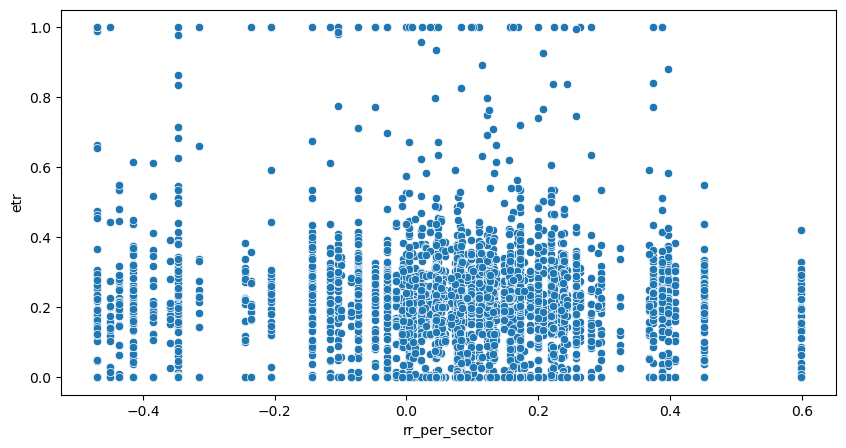

In [231]:
quick_viz(df.rr_per_sector)

#### Interactions

In [232]:
print(
    stats.kruskal(df[df.dta == 0]["diff"], df[df.dta == 1]["diff"])
)  # statistically siginificant difference on medians

KruskalResult(statistic=5.071800156967217, pvalue=0.02431811710197139)


In [233]:
df["diff_dta"] = df["diff"] * df.dta
df_test["diff_dta"] = df_test["diff"] * df_test.dta

In [234]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 99) (363, 99)
True


In [235]:
pd.crosstab(df["cfc"], df["dta"])

dta,0,1
cfc,,
0,2117,0
1,936,940


In [236]:
df["cfc_dta"] = df["cfc"] * df["dta"]
df_test["cfc_dta"] = df_test["cfc"] * df_test["dta"]

In [237]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 100) (363, 100)
True


#### Time-series approach

#### etr

Let's investigate if there is a sense to use shifting of y_t. We assume based on EDA that etr is stationary for many companies!

In [238]:
import warnings

warnings.filterwarnings("ignore")

In [239]:
X = df[["Ticker", "etr"]]

In [240]:
models = list()
for i in df.Ticker.unique():
    stepwise_model = auto_arima(
        X[X.Ticker == i].etr.tolist(),
        start_p=1,
        start_q=1,
        max_p=3,
        max_q=3,
        m=1,
        start_P=0,
        seasonal=False,
        d=0,
        D=0,
        suppress_warnings=True,
        stepwise=True,
        information_criterion="hqic",
    )
    models.append(stepwise_model.order)

In [241]:
modelsDF = pd.DataFrame(models)

In [242]:
modelsDF[0].value_counts()

0    231
1     93
2     33
3      6
Name: 0, dtype: int64

In [243]:
modelsDF[2].value_counts()

0    272
1     75
2     16
Name: 2, dtype: int64

We see that AR(1) and AR(2) process is irrelevant in case of 86% of companies. Nevertheless let's add such variable like y_t shift. We will remove it if it will be redundant in models.

MA process occured in case of  33% of companies!

In [244]:
df["etr_y_past"] = np.nan

In [245]:
for i in df.Ticker.unique():
    df.loc[df.Ticker == i, "etr_y_past"] = (
        df.loc[df.Ticker == i, "etr"].shift(1).fillna(value=None, method="backfill")
    )

In [246]:
df_test["etr_y_past"] = np.nan

In [247]:
for i in df_test.Ticker.unique():
    df_test.loc[df_test.Ticker == i, "etr_y_past"] = df.loc[df.Ticker == i, "etr"].iloc[
        -1
    ]

In [248]:
df["etr_y_ma"] = np.nan

In [249]:
for i in df.Ticker.unique():
    df.loc[df.Ticker == i, "etr_y_ma"] = (
        df.loc[df.Ticker == i, "etr"]
        .shift(1)
        .rolling(2)
        .mean()
        .fillna(value=None, method="backfill")
    )

In [250]:
df_test["etr_y_ma"] = np.nan

In [251]:
for i in df.Ticker.unique():
    df_test.loc[df_test.Ticker == i, "etr_y_ma"] = (
        df.loc[df.Ticker == i, "etr"].rolling(2).mean().iloc[-1]
    )

In [252]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 102) (363, 102)
True


Let's consider other variables to such procedure

In [253]:
to_check = [
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
]

In [254]:
for i in to_check:
    X = df[["Ticker", i]]
    models = list()
    for j in df.Ticker.unique():
        stepwise_model = auto_arima(
            X.loc[X.Ticker == j, i].tolist(),
            start_p=1,
            start_q=1,
            max_p=2,
            max_q=2,
            m=1,
            start_P=0,
            seasonal=False,
            d=0,
            D=0,
            suppress_warnings=True,
            stepwise=True,
            information_criterion="hqic",
        )
        models.append(stepwise_model.order)
    modelsDF = pd.DataFrame(models)
    print(
        i,
        "===> AR: ",
        (1 - modelsDF[0].value_counts()[0] / len(modelsDF[0])),
        "MA: ",
        (1 - (modelsDF[2].value_counts()[0] / len(modelsDF[2]))),
    )

diff ===> AR:  0.22314049586776863 MA:  0.11019283746556474
roa ===> AR:  0.3994490358126722 MA:  0.2672176308539945
lev ===> AR:  0.4931129476584022 MA:  0.27548209366391185
intan ===> AR:  0.5426997245179064 MA:  0.2644628099173554
rd ===> AR:  0.2286501377410468 MA:  0.0826446280991735
ppe ===> AR:  0.5234159779614325 MA:  0.30578512396694213
sale ===> AR:  0.49035812672176304 MA:  0.35812672176308535
cash_holdings ===> AR:  0.3663911845730028 MA:  0.25068870523415976
adv_expenditure ===> AR:  0.04132231404958675 MA:  0.0055096418732781816


In [255]:
MA_apply = ["diff", "roa", "lev", "intan", "ppe", "sale", "cash_holdings"]

In [256]:
for j in MA_apply:
    tmp = j + "_ma"
    df[tmp] = np.nan
    for i in df.Ticker.unique():
        df.loc[df.Ticker == i, tmp] = (
            df.loc[df.Ticker == i, j]
            .shift(1)
            .rolling(2)
            .mean()
            .fillna(value=None, method="backfill")
        )

    df_test[tmp] = np.nan
    for i in df.Ticker.unique():
        df_test.loc[df_test.Ticker == i, tmp] = (
            df.loc[df.Ticker == i, j].rolling(2).mean().iloc[-1]
        )

In [257]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 109) (363, 109)
True


In [258]:
AR_apply = ["roa", "lev", "intan", "ppe", "sale", "cash_holdings"]

In [259]:
for j in AR_apply:
    tmp = j + "_past"
    df[tmp] = np.nan
    for i in df.Ticker.unique():
        df.loc[df.Ticker == i, tmp] = (
            df.loc[df.Ticker == i, j].shift(1).fillna(value=None, method="backfill")
        )

    df_test[tmp] = np.nan
    for i in df.Ticker.unique():
        df_test.loc[df_test.Ticker == i, tmp] = df.loc[df.Ticker == i, j].iloc[-1]

In [260]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 115) (363, 115)
True


In [286]:
df.to_csv(f"{preprocessed_output_data_path}/train_fe.csv")
df_test.to_csv(f"{preprocessed_output_data_path}/test_fe.csv")

## Feature selection

In this chapter we will build general intuition regarding features in our dataset! We will perform additional feature selection for every model.

### Univariate approach -  filter methods

In [287]:
x_col = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "ta_log",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "ppent_sqrt",
    "intant_sqrt",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "rd_sqrt",
    "ppe_clip",
    "cash_holdings_sqrt",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [288]:
y_col = "etr"

In [297]:
general_ranking = pd.DataFrame(index=x_col)

#### Variance Threshold

In [298]:
sel = VarianceThreshold(0.01)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)

In [299]:
col_redundant

{'adv_cat_(874.5, inf]',
 'adv_expenditure',
 'capex2_scaled',
 'cash_holdings',
 'cash_holdings_ma',
 'cash_holdings_past',
 'pi_cat_(7875.5, 8108.5]',
 'rd',
 'str',
 'txt_cat_(-63.011, -34.811]',
 'txt_cat_(24.415, 25.05]',
 'txt_cat_(308.55, 327.531]',
 'y_BR_Democracy',
 'y_v2x_polyarchy'}

#### Mutual Information

In [300]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values)[0]})

In [301]:
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

In [302]:
miDF.sort_values(by="score").head(10)

,score
y_BR_Democracy,0.000000
"pi_cat_(7875.5, 8108.5]",0.000000
"dlc_cat_(176.129, 200.9]",0.001890
ni_profit_20000,0.002128
"txt_cat_(-63.011, -34.811]",0.005236
"pi_cat_(8108.5, inf]",0.008406
"capex_cat_(5451.0, inf]",0.010369
"txt_cat_(24.415, 25.05]",0.010370
sektor_energy,0.011313
"txt_cat_(308.55, 327.531]",0.011710


In [303]:
miDF.sort_values(by="score", ascending=False).head(10)

,score
etr_y_past,1.009402
etr_y_ma,0.825650
txt,0.633067
diff,0.632640
ni,0.613297
pi,0.608157
intant,0.600611
intant_sqrt,0.589341
ta,0.582922
revenue,0.577486


In [304]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)

In [305]:
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

#### F-test

In [306]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
fscore = dict()
for i in x_col:
    fscore.update({i: f_regression(df[[i]].values, df[y_col].values)[1]})

In [307]:
fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])

In [308]:
fscoreDF.sort_values(by="p_value_score").head(10)

,p_value_score
etr_y_ma,2.473770e-125
etr_y_past,1.304040e-84
"str_cat_(0.0875, 0.192]",1.429045e-51
WB_GDPpc,2.661700e-49
"str_cat_(0.28, inf]",3.990448e-49
cfc,9.686699e-47
str,1.578384e-46
"revenue_cat_(0.174, 1248.817]",2.618037e-39
"txt_cat_(-34.811, 0.488]",1.108825e-32
"revenue_cat_(4233.587, inf]",4.246614e-32


In [309]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

,p_value_score
y_BR_Democracy,1.000000
sektor_energy,0.830726
cash_holdings_past,0.812166
cash_holdings_sqrt,0.638415
cash_holdings_ma,0.580102
sektor_health care,0.532034
gielda_5,0.513150
sektor_utilities,0.489521
"dltt_cat_(39.38, 327.85]",0.453214
dltt,0.358743


In [310]:
fscoreDF["sign"] = np.where(fscoreDF.p_value_score < 0.1, 1, 0)

In [311]:
general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)

In [312]:
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

#### Correlation - Spearman

We are aware that we rather should not apply correlation on dichotomous variables!

In [313]:
corr = list()
for i in x_col:
    corr.append(stats.spearmanr(df.loc[:, y_col].values, df.loc[:, i].values)[0])

In [314]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

### Multivariate approach - wrapper methods

#### Elastic Net

code based on: https://www.kaggle.com/cast42/feature-selection-and-elastic-net

In [315]:
en_res = pd.DataFrame(index=x_col)

In [319]:
def rmse_cv(model):
    rmse = np.sqrt(
        -cross_val_score(
            model,
            df.loc[:, x_col],
            df.loc[:, y_col],
            scoring="neg_mean_squared_error",
            cv=5,
        )
    )
    return rmse

In [322]:
alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
l1_ratios = [1, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3]

In [323]:
cv_elastic = [
    rmse_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio)).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

Text(0, 0.5, 'rmse')

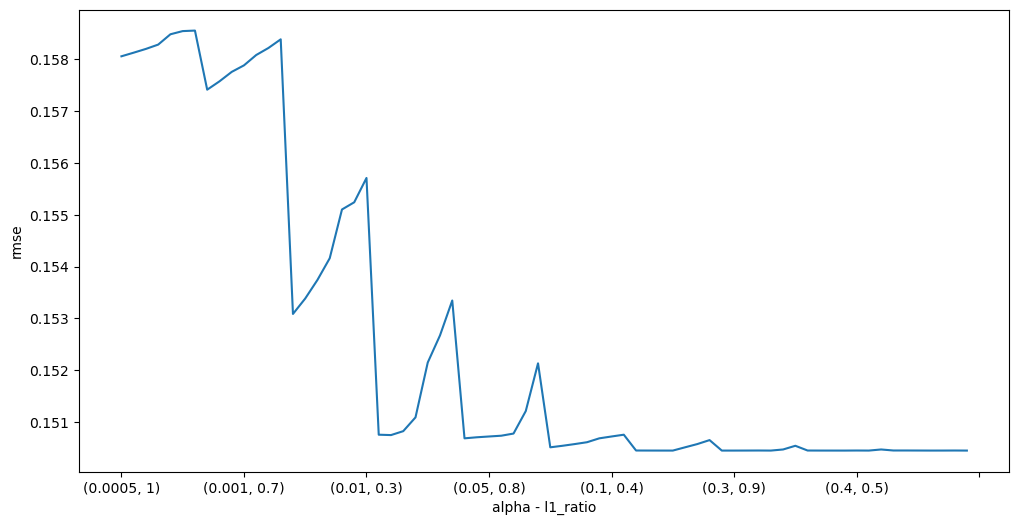

In [324]:
plt.rcParams["figure.figsize"] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index=idx)
p_cv_elastic.plot()
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

In [325]:
elastic = ElasticNet(alpha=0.2, l1_ratio=0.5)

In [326]:
elastic.fit(df.loc[:, x_col], df.loc[:, y_col])

ElasticNet(alpha=0.2)

In [327]:
coef = pd.Series(elastic.coef_, index=df.loc[:, x_col].columns)

In [328]:
print(
    "Elastic Net picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)

Elastic Net picked 14 variables and eliminated the other 98 variables


In [329]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

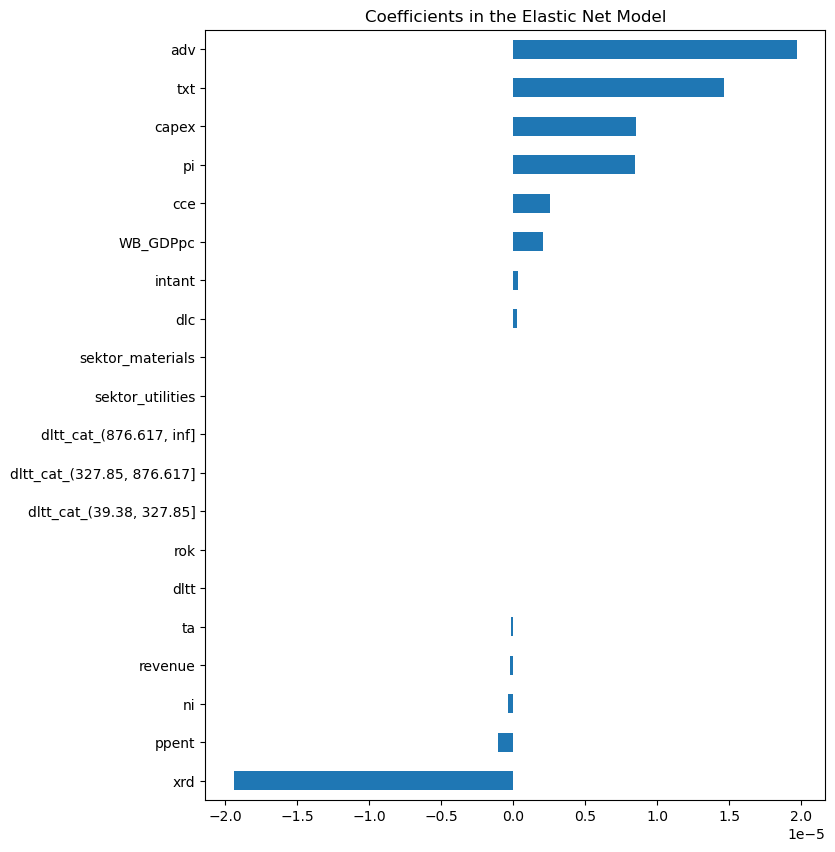

In [330]:
plt.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Elastic Net Model")

In [331]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(imp_coef),
    left_index=True,
    right_index=True,
    how="left",
)

In [332]:
general_ranking.rename(columns={0: "EN_coef"}, inplace=True)

#### Boruta

In [333]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

In [334]:
feat_selector = bp(rf, n_estimators="auto", verbose=0, max_iter=100)

In [335]:
df.loc[:, x_col]

,rok,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation,rr_per_country,rr_per_sector,sektor_consumer discretionary,sektor_consumer staples,sektor_energy,sektor_health care,sektor_industrials,sektor_materials,sektor_real estate,sektor_technology,sektor_utilities,gielda_2,gielda_3,gielda_4,gielda_5,ta_log,"txt_cat_(-63.011, -34.811]","txt_cat_(-34.811, 0.488]","txt_cat_(0.488, 24.415]","txt_cat_(24.415, 25.05]","txt_cat_(25.05, 308.55]","txt_cat_(308.55, 327.531]","txt_cat_(327.531, inf]","pi_cat_(-8975.0, -1.523]","pi_cat_(-1.523, 157.119]","pi_cat_(157.119, 465.9]","pi_cat_(465.9, 7875.5]","pi_cat_(7875.5, 8108.5]","pi_cat_(8108.5, inf]","str_cat_(0.0875, 0.192]","str_cat_(0.192, 0.28]","str_cat_(0.28, inf]",xrd_exists,ni_profit,ni_profit_20000,ppent_sqrt,intant_sqrt,"dlc_cat_(42.262, 176.129]","dlc_cat_(176.129, 200.9]","dlc_cat_(200.9, inf]","dltt_cat_(39.38, 327.85]","dltt_cat_(327.85, 876.617]","dltt_cat_(876.617, inf]","capex_cat_(7.447, 79.55]","capex_cat_(79.55, 5451.0]","capex_cat_(5451.0, inf]","revenue_cat_(0.174, 1248.817]","revenue_cat_(1248.817, 4233.587]","revenue_cat_(4233.587, inf]","cce_cat_(5.619, 63.321]","cce_cat_(63.321, inf]","adv_cat_(0.3, 874.5]","adv_cat_(874.5, inf]",diff_positive,roa_clip,lev_sqrt,intan_pow2,rd_sqrt,ppe_clip,cash_holdings_sqrt,adv_expenditure_positive,diff_dta,cfc_dta,etr_y_past,etr_y_ma,diff_ma,roa_ma,lev_ma,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
0,2005,21.127613,1.24185,6.329725,0.19,0.0,5.087900,0.276275,4.195900,0.000,0.000000,2.223413,11.873301,12.142975,0.0,-0.006193,0.240818,0.000000,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.030010,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.048390,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.000000,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744
1,2006,21.127613,1.24185,6.329725,0.19,0.0,5.087900,0.276275,4.195900,0.000,0.000000,2.223413,11.873301,12.142975,0.0,-0.006193,0.240818,0.000000,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.884,10,1,6.179641,9038.730847,1.284694,0.421396,0.136194,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.048390,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.000000,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744
2,2007,21.127613,1.24185,6.329725,0.19,0.0,5.087900,0.276275,4.195900,0.000,0.000000,2.223413,11.873301,12.142975,0.0,-0.006193,0.240818,0.000000,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.887,10,1,7.034828,11255.436700,2.458743,0.104220,0.035493,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.048390,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.000000,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744
3,2008,21.127613,1.24185,6.329725,0.19,0.0,5.087900,0.276275,4.195900,0.000,0.000000,2.223413,11.873301,12.142975,0.0,-0.006193,0.240818,0.000000,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.869,10,1,4.249609,14001.446880,4.164972,-0.511178,-0.384695,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.048390,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.000000,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,0.240818,0.000000,0.1985

In [336]:
feat_selector.fit(df.loc[:, x_col].values, df.loc[:, y_col].values.ravel())

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=74,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1088AD540),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x1088AD540)

In [337]:
feat_selector.ranking_

array([ 19,  49,   1,   3,   9,  12,   7,  25,  41,  19,  54,  29,  16,
        26,  53,   1,  22,  36,  59,  44,  34,  12,  48,  69,  30,  17,
        66,  38,  57,  88, 106,  24,   1,  32,  46,  21,  71,  87,  93,
       104,  88,  60,  83,  95,  91,  68,  72,  92, 102,  46,   3,  62,
        76,  11,  76,   5, 104,  86,  64,  81,  95,   6, 104,  61,  90,
        45,  66,  70,  97,  26,  37,  99,   2,  63,  79,  74, 101,  84,
        66,  23,  78,  81,  94,  98,  79, 100, 106,  84,  18,  39,  57,
        51,  31,  49,  72,  14,  75,   1,   1,   1,  28,  15,  56,  32,
        34,  42,   7,  10,  51,  40,  43,  55])

In [338]:
boruta_DF = pd.DataFrame(index=x_col)

In [339]:
boruta_DF["boruta_rank"] = feat_selector.ranking_

In [340]:
general_ranking = pd.merge(
    general_ranking, boruta_DF, left_index=True, right_index=True, how="left"
)

#### SUMMARY OF FEATURE SELECTION

In [341]:
pd.set_option("display.max_rows", 500)

This table generates overview, which will be useful in case of further feature selection per each model!

In [342]:
general_ranking.sort_values(["mi_score", "boruta_rank", "corr"], ascending=False)

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
etr_y_past,1.009402,1.304040e-84,1,0.520405,NaN,1
etr_y_ma,0.825650,2.473770e-125,1,0.526871,NaN,1
txt,0.633067,5.246456e-13,1,0.368732,1.466269e-05,1
diff,0.632640,2.257712e-02,1,-0.291716,NaN,1
ni,0.613297,1.747230e-09,1,0.263458,-3.442000e-07,7
pi,0.608157,8.614688e-12,1,0.299593,8.453656e-06,3
intant,0.600611,3.058156e-13,1,0.296425,3.013313e-07,41
intant_sqrt,0.589341,8.457669e-25,1,0.296425,NaN,37
ta,0.582922,1.464884e-03,1,0.267340,-1.404307e-07,49
revenue,0.577486,1.963958e-10,1,0.304957,-2.057508e-07,16


In [343]:
general_ranking.to_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx")